In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import os
import re
from sklearn.feature_extraction.text import CountVectorizer
from numpy.linalg import norm
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN, KMeans
from sklearn.preprocessing import normalize,  MaxAbsScaler
from datetime import timedelta
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from wordcloud import WordCloud

#### Cybersecurity training

#### Paper

V. Švábenský, J. Vykopal, P. Čeleda, K. Tkáčik, and D. Popovič: Student Assessment in Cybersecurity Training Automated by Pattern Mining and Clustering, Springer Education and Information Technologies, 2022, ISSN 1360-2357, DOI: https://doi.org/10.1007/s10639-022-10954-4

https://archive.ics.uci.edu/dataset/869/shell+commands+used+by+participants+of+hands-on+cybersecurity+training



The dataset are the executed shell commands in terminal applications used for different cybersecurity training programs. The data are all stored in json files. Each json file contains the executed commands by a participant in one virtual session. As such, wihin each training program's dataset folder, the virtual sessions are unique, but different programs can share the same virtual session id number. There are different cybersecurity training programs  used during these training sessions such as Junior hacker and Secret Laboratory games, House of Cards etc. 

The aim is to use a density clustering algorithm on bag-of-words matrix and a matrix of computed features. The results of clustering these two matrices will form the basis for student assessment and insights into student learning.

### Data Preview

The trainees completed a sequence of assignments presented via a web interface.

Each trainee participated in exactly one of two types of training. Both trainings involved attacking an intentionally vulnerable virtual host using well-known security tools, but the trainings slightly differed in their content. In Training A (72 participants), the following tools were crucial: nmap for network scanning, Metasploit for exploitation, john for password cracking, and ssh for remote connection. Training B (41 participants) used nmap and ssh as well, but not Metasploit or john. Instead, it featured fcrackzip for cracking passwords to ZIP files

Seven hands-on cybersecurity trainings that comprise the dataset and the key command-line tools:

Junior hacker               - nmap, scp, ssh, fcrackzip

Junior hacker adaptive      - nmap, scp, ssh, fcrackzip 

Kobylka 3302                - nmap, Metasploit modules, john, ssh

Secret laboratory           - nmap, Metasploit modules, john, ssh

Webmin exploit practice     - nmap, Metasploit modules, john, ssh

House of cards              - nmap, Metasploit modules, ssh

SQL injection               - sqlmap, ssh

V. Švábenský, J. Vykopal and P. Seda et al. / Data in Brief 38 (2021) 

The data dictionary is found in the paper, V. Švábenský, J. Vykopal and P. Seda et al. / Data in Brief 38 (2021) 107398.

The description the data fields inside each json file is as follows :

• timestamp_str represents the time of the command’s submission in the ISO 8601 format (up to millisecond or microsecond precision).

• cmd is the full command (the tool name and its arguments) submitted by the trainee.

• cmd_type is the application used to execute the command: either bash-command for the
tools executed from Bash/ZSH, or msf-command for Metasploit shell.

• username is the account name on the sandboxed machine under which the command was executed. The account names are set by the training author, and they never store personal
information of the trainee. username is stored only for the bash-command type.

• hostname is the name of the machine in the sandbox on which the command was executed.

• ip is the IPv4 address of the corresponding virtual host in the sandbox. The IP addresses do
not represent any real machine on the Internet.

• wd is the working directory in which the command was executed. Combined with the data
fields above, the trainees’ command-line prompt looks like this: username@hostnamewd$,
e.g., root@attacker/home$ for Listing 1. wd is stored only for the bash-command type.

• sandbox_id is an arbitrary numerical identifier of the trainee’s sandbox. It is a duplicate of
the id in the filename sandbox-id-useractions.json for sanity checks.

• pool_id is an arbitrary numerical identifier that associates the sandboxes from one training
session into a so-called pool. All sandboxes from the same session belong to the same pool.

The dataset was loaded with pd.read_json(), making sure to set the argument lines=True because each .json file contains lines of json objects. The tools used in secret laboratory, locusts 3302, house of cards and webmin exploit
training programs match up with training A. The tools used in junior hacker and junior hacker adaptive align up with training b. The clustering process can be applied to training A or training B or a selection of both. SQL injection doesnt line up with either training and could be added or left out of the clustering exercise.


The datasets of the chosen programs are read into dataframes and then concatenated to have the project dataset. We also convert the string timestamp to a datetime object, and when we check the null count, we find only username and working directory (wd) columns contain null values and these column nulls also occur together, meaning rows with null usernames also have null wd (working directory). 

According to data dictionary (found in the paper, V. Švábenský, J. Vykopal and P. Seda et al. / Data in Brief 38 (2021) 107398), wd were only stored for bash command_type. We can confirm that all msf-command had null usernames and wd in addition to some bash command_type.

The pool_id basically identifies the training session; the dataframe contains info from 13 training sessions. As such all sandboxes from the same training session belongs to the same pool. But since virtual sessions from different games can have the same sandbox id, we create a column adding an initial for the training program to the sandbox_id and this will be the identifier of the commands belonging to the user of that particular sandbox for that training program. 

In [2]:
# Get current path
current_path = os.getcwd()
current_path

'/Users/godfredowusu/Desktop/mlbooklearn/cybersecurity_training'

In [3]:
# folders and files in current path
os.listdir(current_path)

['.DS_Store',
 '[PDF] Student assessment in cybersecurity training automated by pattern mining and clustering | Semantic Scholar.pdf',
 'Dataset of shell commands used by participants of hands-on cybersecurity training.pdf',
 'cybersec_training.ipynb',
 'data-2',
 'data',
 'Student assessment in cybersecurity training automated by pattern mining and clustering | Semantic Scholar.pdf',
 'commands-master.zip']

In [4]:
# data path for cybersecurity game folders
data_path =os.path.join(current_path, 'data')
os.listdir(data_path)

['Secret laboratory',
 'Locust 3302',
 '.DS_Store',
 'Webmin exploit practice',
 'House of cards',
 'README.md',
 'SQL injection',
 'Junior hacker',
 'Junior hacker adaptive']

In [5]:
# Junior hacker folders and files
os.listdir(os.path.join(data_path, 'Junior hacker'))

['.DS_Store', '2021-02-08', 'topology.yml']

In [6]:
# Junior hacker adaptive folders and files
os.listdir(os.path.join(data_path, 'Junior hacker adaptive'))

['2021-09-09',
 '.DS_Store',
 '2021-05-26',
 '2021-05-28',
 '2020-12-02',
 '2020-12-04',
 'topology.yml',
 '2020-12-11',
 '2021-05-25',
 '2021-01-14']

In [7]:
# Secret Laboratory folders and files
os.listdir(os.path.join(data_path, 'Secret laboratory'))

['sandbox-342-useractions.json',
 'sandbox-124-useractions.json',
 'sandbox-130-useractions.json',
 'sandbox-125-useractions.json',
 'sandbox-131-useractions.json',
 'sandbox-129-useractions.json',
 'sandbox-126-useractions.json',
 'sandbox-3-useractions.json',
 'sandbox-340-useractions.json',
 'topology.yml',
 'sandbox-123-useractions.json',
 'sandbox-128-useractions.json',
 'sandbox-341-useractions.json',
 'sandbox-127-useractions.json']

In [8]:
# Secret Laboraty game folder location
secret_lab = os.path.join(data_path, 'Secret laboratory')
secret_lab

'/Users/godfredowusu/Desktop/mlbooklearn/cybersecurity_training/data/Secret laboratory'

In [9]:
# Function to load json files stored inside date folders in training data folder
def get_cybtrndata_nested(training_name, idf):
    current_path = os.getcwd()          # get current working directory
    training_folder = os.path.join(current_path,'data',training_name) # training data path
    df = pd.DataFrame()                      # initialize empty dataframe
    for folder in os.listdir(training_folder):     # list all files and training date folder names 
        if folder in ('.DS_Store',  'topology.yml'):  # i expect a date folder
            continue
        folder_path = os.path.join(training_folder, folder)    # training for a specific date
        folder_files = os.listdir(folder_path)          # read the json files
        for file in folder_files:
            if file[-4:] == 'json':             # only the json files are terminal files
                #print(file)                    # print file name string
                file_path = os.path.join(folder_path,file)       # create filepath string for file
                df_file = pd.read_json(file_path, lines=True)  # lines=True cuz each line is new json 
                df = pd.concat([df, df_file])   # concatenate
    df.insert(0,'training',training_name)
    df['training_id'] =  idf + '_' + df.sandbox_id.astype('str')
    return df

In [10]:
# Function to load json files stored inside training data folder
def get_cybtrndata_flat(training_name, idf):
    current_path = os.getcwd()          # get current working directory
    training_folder = os.path.join(current_path,'data',training_name) # training data path
    df = pd.DataFrame()                      # initialize empty dataframe
    for file in os.listdir(training_folder): # iterate through json files
        if file[-4:] == 'json':             # only the json files are terminal files
            #print(file)                    # print file name string
            file_path = os.path.join(training_folder,file)       # create filepath string for file
            df_file = pd.read_json(file_path, lines=True)   # lines=True cuz each line is json object in file
            df = pd.concat([df, df_file])   # concatenate
    df.insert(0,'training',training_name)
    df['training_id'] =  idf + '_' + df.sandbox_id.astype('str')
    return df

In [11]:
# Training Program names and file structure (flat or nested)
['Secret laboratory',               # flat   - json files are in the training folder
 'Webmin exploit practice',         # flat
 'House of cards',                  # nested - json files are inside dated folders in the training folder
 'Locust 3302',                     # nested
 
 'SQL injection',                   # flat

 'Junior hacker',                   # nested
 'Junior hacker adaptive'           # nested
 ]          

['Secret laboratory',
 'Webmin exploit practice',
 'House of cards',
 'Locust 3302',
 'SQL injection',
 'Junior hacker',
 'Junior hacker adaptive']

In [12]:
# Training A data
df_sl = get_cybtrndata_flat('Secret laboratory', 'sl')
df_wb = get_cybtrndata_flat('Webmin exploit practice', 'wb')
df_hc = get_cybtrndata_nested('House of cards', 'hc')
df_lc = get_cybtrndata_nested('Locust 3302', 'lc')

df = pd.concat([df_sl, df_wb,df_hc, df_lc])
df.shape

(14662, 12)

In [13]:
#Training B data

#df_jh = get_cybtrndata_nested('Junior hacker', 'jh')
#df_jha = get_cybtrndata_nested('Junior hacker adaptive', 'jha')
#df = pd.concat([df_jh, df_jha])
#df.shape

In [14]:
# convert the timestamp_str to datetime objects; specify format resolve to UTC
pd.to_datetime(df_sl.timestamp_str, format='ISO8601', utc=True)

0    2020-05-14 08:34:24.500753+00:00
1    2020-05-14 08:37:24.451194+00:00
2    2020-05-14 08:38:07.692940+00:00
3    2020-05-14 08:38:35.308710+00:00
4    2020-05-14 08:42:11.927047+00:00
                   ...               
54   2021-06-30 08:41:24.865000+00:00
55   2021-06-30 08:42:39.914000+00:00
56   2021-06-30 08:42:49.936000+00:00
57   2021-06-30 08:42:59.107000+00:00
58   2021-06-30 08:43:44.970000+00:00
Name: timestamp_str, Length: 1260, dtype: datetime64[ns, UTC]

In [15]:
df.shape

(14662, 12)

In [16]:
# convert timestamp from string to geography-independent utc format
df['timestamp_dt'] = pd.to_datetime(df.timestamp_str, format='ISO8601', utc=True)
df.head()

,training,cmd_type,pool_id,sandbox_id,timestamp_str,hostname,cmd,username,wd,ip,training_id,tags,timestamp_dt
0,Secret laboratory,bash-command,1,342,2020-05-14T10:34:24.500753+02:00,attacker,man nmap,root,/root,10.1.135.83,sl_342,NaN,2020-05-14 08:34:24.500753+00:00
1,Secret laboratory,bash-command,1,342,2020-05-14T10:37:24.451194+02:00,attacker,man nmap,root,/root,10.1.135.83,sl_342,NaN,2020-05-14 08:37:24.451194+00:00
2,Secret laboratory,bash-command,1,342,2020-05-14T10:38:07.692940+02:00,attacker,nmap -sL 10.1.26.9,root,/root,10.1.135.83,sl_342,NaN,2020-05-14 08:38:07.692940+00:00
3,Secret laboratory,bash-command,1,342,2020-05-14T10:38:35.308710+02:00,attacker,nmap 10.1.26.9,root,/root,10.1.135.83,sl_342,NaN,2020-05-14 08:38:35.308710+00:00
4,Secret laboratory,bash-command,1,342,2020-05-14T10:42:11.927047+02:00,attacker,nmap -p 10000,root,/root,10.1.135.83,sl_342,NaN,2020-05-14 08:42:11.927047+00:00


In [17]:
# sort by virtual session id (sandbox_id) and datetime timestamp
df = df.sort_values(by=['training', 'sandbox_id', 'timestamp_dt'])
df.head()

,training,cmd_type,pool_id,sandbox_id,timestamp_str,hostname,cmd,username,wd,ip,training_id,tags,timestamp_dt
0,House of cards,bash-command,0,93,2019-12-08 14:31:41.334748+00:00,attacker,nmap -h,root,/root,10.0.135.83,hc_93,NaN,2019-12-08 14:31:41.334748+00:00
1,House of cards,bash-command,0,93,2019-12-08 14:32:04.194314+00:00,attacker,nmap -sS 100.100.100.4,root,/root,10.0.135.83,hc_93,NaN,2019-12-08 14:32:04.194314+00:00
2,House of cards,bash-command,0,93,2019-12-08 14:32:50.135090+00:00,attacker,nmap -sS -p- 100.100.100.4,root,/root,10.0.135.83,hc_93,NaN,2019-12-08 14:32:50.135090+00:00
3,House of cards,bash-command,0,93,2019-12-08 14:33:20.620505+00:00,attacker,ssh 100.100.100.4,root,/root,10.0.135.83,hc_93,NaN,2019-12-08 14:33:20.620505+00:00
4,House of cards,msf-command,0,93,2019-12-08 14:44:16.001640+00:00,attacker,back,NaN,NaN,10.0.135.83,hc_93,NaN,2019-12-08 14:44:16.001640+00:00


In [18]:
# current index
df.index

Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9,
       ...
       25, 26, 27, 28, 29, 30, 31, 32, 33, 34],
      dtype='int64', length=14662)

In [19]:
# reset_index() after concatenation
df = df.reset_index(drop=True)
df.head()

,training,cmd_type,pool_id,sandbox_id,timestamp_str,hostname,cmd,username,wd,ip,training_id,tags,timestamp_dt
0,House of cards,bash-command,0,93,2019-12-08 14:31:41.334748+00:00,attacker,nmap -h,root,/root,10.0.135.83,hc_93,NaN,2019-12-08 14:31:41.334748+00:00
1,House of cards,bash-command,0,93,2019-12-08 14:32:04.194314+00:00,attacker,nmap -sS 100.100.100.4,root,/root,10.0.135.83,hc_93,NaN,2019-12-08 14:32:04.194314+00:00
2,House of cards,bash-command,0,93,2019-12-08 14:32:50.135090+00:00,attacker,nmap -sS -p- 100.100.100.4,root,/root,10.0.135.83,hc_93,NaN,2019-12-08 14:32:50.135090+00:00
3,House of cards,bash-command,0,93,2019-12-08 14:33:20.620505+00:00,attacker,ssh 100.100.100.4,root,/root,10.0.135.83,hc_93,NaN,2019-12-08 14:33:20.620505+00:00
4,House of cards,msf-command,0,93,2019-12-08 14:44:16.001640+00:00,attacker,back,NaN,NaN,10.0.135.83,hc_93,NaN,2019-12-08 14:44:16.001640+00:00


In [20]:
# verify new index
df.index

RangeIndex(start=0, stop=14662, step=1)

In [21]:
# different sandbox id in the dataset (sandbox id is the id for each virtual session)
df.sandbox_id.unique()

array([ 93,  95, 101, 112, 113, 115, 116, 130, 131, 137, 144, 148, 149,
       151, 152, 156, 396, 397, 398, 399, 400, 401,  22,  23,  24,  25,
        26,  28,  29,  30,  31,  42,  43,  44,  45,  46,  47,  48,  49,
        50,  51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,
        63,  64,  65,  66,  67,  68,  69,  70,  71,  73,  77,  79,  80,
        82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,  94,  96,
        97,  98,  99, 100, 102, 128, 129, 172, 185, 187, 188, 195, 643,
       644, 645, 646, 647, 648, 649, 650, 651, 652, 653, 654, 655, 656,
       660, 661, 662, 663, 664, 665, 666, 667, 668, 669, 670, 671, 672,
       673, 674, 675, 676, 680, 681, 682, 683, 684, 685, 686, 687, 688,
       690, 691, 692, 693, 694, 695, 696, 714,   3, 123, 124, 125, 126,
       127, 340, 341, 342, 315, 316, 317, 327, 328, 329, 331, 351, 358,
       374])

In [22]:
# null values per column
df.isna().sum(axis=0)

training             0
cmd_type             0
pool_id              0
sandbox_id           0
timestamp_str        0
hostname             0
cmd                 19
username          5043
wd                5043
ip                   0
training_id          0
tags             14643
timestamp_dt         0
dtype: int64

In [23]:
# the username and working directory are Null for the same rows
df[df.username.isna()]

,training,cmd_type,pool_id,sandbox_id,timestamp_str,hostname,cmd,username,wd,ip,training_id,tags,timestamp_dt
4,House of cards,msf-command,0,93,2019-12-08 14:44:16.001640+00:00,attacker,back,NaN,NaN,10.0.135.83,hc_93,NaN,2019-12-08 14:44:16.001640+00:00
5,House of cards,msf-command,0,93,2019-12-08 14:45:29.397084+00:00,attacker,exit,NaN,NaN,10.0.135.83,hc_93,NaN,2019-12-08 14:45:29.397084+00:00
7,House of cards,msf-command,0,93,2019-12-08 14:46:39.149326+00:00,attacker,exit,NaN,NaN,10.0.135.83,hc_93,NaN,2019-12-08 14:46:39.149326+00:00
8,House of cards,msf-command,0,93,2019-12-08 14:47:07.019673+00:00,attacker,back,NaN,NaN,10.0.135.83,hc_93,NaN,2019-12-08 14:47:07.019673+00:00
40,House of cards,msf-command,0,93,2019-12-08 20:11:51.187615+00:00,attacker,options,NaN,NaN,10.0.135.83,hc_93,NaN,2019-12-08 20:11:51.187615+00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
14655,Webmin exploit practice,msf-command,1,374,2020-05-14 11:20:45.479996+02:00,attacker,use exploit/unix/webapp/webmin_upload_exec,NaN,NaN,10.1.135.83,wb_374,NaN,2020-05-14 09:20:45.479996+00:00
14656,Webmin exploit practice,msf-command,1,374,2020-05-14 11:22:52.136027+02:00,attacker,exit,NaN,NaN,10.1.135.83,wb_374,NaN,2020-05-14 09:22:52.136027+00:00
14658,Webmin exploit practice,msf-command,1,374,2020-05-14 11:23:53.519029+02:00,attacker,use exploit/unix/webapp/webmin_upload_exec > s...,NaN,NaN,10.1.135.83,wb_374,NaN,2020-05-14 09:23:53.519029+00:00
14659,Webmin exploit practice,msf-command,1,374,2020-05-14 11:24:16.022195+02:00,attacker,exploit,NaN,NaN,10.1.135.83,wb_374,NaN,2020-05-14 09:24:16.022195+00:00


In [24]:
# command application types with null usernames
df[df.username.isna()].cmd_type.unique()

array(['msf-command', 'bash-command'], dtype=object)

In [25]:
# types of terminal applications used
df.cmd_type.unique()

array(['bash-command', 'msf-command'], dtype=object)

In [26]:
# number of training sessions captured by dataset
df.pool_id.nunique()

13

In [27]:
# command column
df.cmd

0                                                  nmap -h
1                                   nmap -sS 100.100.100.4
2                               nmap -sS -p- 100.100.100.4
3                                        ssh 100.100.100.4
4                                                     back
                               ...                        
14657                                           msfconsole
14658    use exploit/unix/webapp/webmin_upload_exec > s...
14659                                              exploit
14660                                                 exit
14661                                           msfconsole
Name: cmd, Length: 14662, dtype: object

In [28]:
# input datatypes 
df.dtypes

training                      object
cmd_type                      object
pool_id                        int64
sandbox_id                     int64
timestamp_str                 object
hostname                      object
cmd                           object
username                      object
wd                            object
ip                            object
training_id                   object
tags                          object
timestamp_dt     datetime64[ns, UTC]
dtype: object

### Bag of Words Matrix

### Data Cleaning

The function for splitting the command into tool name and arguments uses regex to provide a character set of possible delimiters to match on. A character is  a compact way of providing alternations of a single character, in this case the delimiter, including white space, equal signs, colons, hypens, dashes. We make sure that the maxsplit character of re module's split method is set to one so that a single split is done along the delimiter (first delimiter match)  to separate the command into tool name and arguments. The regex module method is used through the .apply() dataframe method, which applies the custom function to the command column. After splitting the command into tool name and argument, two additonal columns are added to include only tool name and only arguments for each command. These columns were further standardized by turning tool names and arguments into lower case.

In [29]:
# split the command into tool and arguments
def valfunc(x): # the command and argument are separated by some delimiter; 
    return re.split(r'[\s*./-=:_]', str(x),  # delimiter is a regex character set of possible delimiters
    maxsplit=1)    # split on matched delimiter once
df['cmd_split'] = df['cmd'].apply(valfunc)   # use .apply() to apply splitting function
df.head()

,training,cmd_type,pool_id,sandbox_id,timestamp_str,hostname,cmd,username,wd,ip,training_id,tags,timestamp_dt,cmd_split
0,House of cards,bash-command,0,93,2019-12-08 14:31:41.334748+00:00,attacker,nmap -h,root,/root,10.0.135.83,hc_93,NaN,2019-12-08 14:31:41.334748+00:00,"[nmap, -h]"
1,House of cards,bash-command,0,93,2019-12-08 14:32:04.194314+00:00,attacker,nmap -sS 100.100.100.4,root,/root,10.0.135.83,hc_93,NaN,2019-12-08 14:32:04.194314+00:00,"[nmap, -sS 100.100.100.4]"
2,House of cards,bash-command,0,93,2019-12-08 14:32:50.135090+00:00,attacker,nmap -sS -p- 100.100.100.4,root,/root,10.0.135.83,hc_93,NaN,2019-12-08 14:32:50.135090+00:00,"[nmap, -sS -p- 100.100.100.4]"
3,House of cards,bash-command,0,93,2019-12-08 14:33:20.620505+00:00,attacker,ssh 100.100.100.4,root,/root,10.0.135.83,hc_93,NaN,2019-12-08 14:33:20.620505+00:00,"[ssh, 100.100.100.4]"
4,House of cards,msf-command,0,93,2019-12-08 14:44:16.001640+00:00,attacker,back,NaN,NaN,10.0.135.83,hc_93,NaN,2019-12-08 14:44:16.001640+00:00,[back]


In [30]:
# result of splitting into tool, arguments
df['cmd_split']

0                                               [nmap, -h]
1                                [nmap, -sS 100.100.100.4]
2                            [nmap, -sS -p- 100.100.100.4]
3                                     [ssh, 100.100.100.4]
4                                                   [back]
                               ...                        
14657                                         [msfconsole]
14658    [use, exploit/unix/webapp/webmin_upload_exec >...
14659                                            [exploit]
14660                                               [exit]
14661                                         [msfconsole]
Name: cmd_split, Length: 14662, dtype: object

In [31]:
# the tool in each command
df['cmd_tool']= df['cmd_split'].apply(lambda x: x[0] if type(x) == list else "")
df['cmd_tool'] = df['cmd_tool'].str.lower()
df['cmd_tool']

0              nmap
1              nmap
2              nmap
3               ssh
4              back
            ...    
14657    msfconsole
14658           use
14659       exploit
14660          exit
14661    msfconsole
Name: cmd_tool, Length: 14662, dtype: object

In [32]:
# get the arguments portion after the tool portion of each command
df['cmd_args'] = df['cmd_split'].apply(lambda x: x[1] if len(x) > 1 else "")
df['cmd_args'] = df['cmd_args'].str.lower()   # standardize by making lowercase


In [33]:
# verify that each command is correctly split into tool and args
df.sample(15)[['cmd','cmd_tool','cmd_args']]

,cmd,cmd_tool,cmd_args
4646,set LHOST 10.1.135.83,set,lhost 10.1.135.83
3696,cd bob,cd,bob
2514,nmap -sT 172.18.1.5,nmap,-st 172.18.1.5
1502,ls,ls,
2540,cat flag.txt,cat,flag.txt
13504,cat research-7.data,cat,research-7.data
12652,python ssh2john.py file > file.hash,python,ssh2john.py file > file.hash
14414,ls,ls,
11217,ssh 172.18.1.5,ssh,172.18.1.5
10621,vim eve_rsa,vim,eve_rsa


In [34]:
# command histories of each participant (sandbox_id) 

def myfunc(x): # x is a column in a dataframe group
    res = []
    for val in x:
        if type(val) == list:
            res.extend(val)
        else:
            res.append(val)
    return res

df_cmd_hist = df.groupby('training_id').agg({'cmd': myfunc,
                                         'cmd_tool': myfunc,
                                         'cmd_args': myfunc
                                         })
df_cmd_hist

,cmd,cmd_tool,cmd_args
training_id,,,
hc_101,"[nmap -sV, nmap --help, nmap -sV 172.18.1.5, n...","[nmap, nmap, nmap, nmap, search, set, set, use...","[-sv, --help, -sv 172.18.1.5, --help, libssh, ..."
hc_112,"[nmap -sP 192.168.0.0-100, ifconfig, nmap --he...","[nmap, ifconfig, nmap, nmap, nmap, nmap, nmap,...","[-sp 192.168.0.0-100, , --help, 172.18.1.5, --..."
hc_113,"[nmap -p 1-1000 172.18.1.5, libssh -h, nmap -p...","[nmap, libssh, nmap, sshlib, sudo, nmap, nmap,...","[-p 1-1000 172.18.1.5, -h, -p 1-56000 172.18.1..."
hc_115,"[libssh, ssh, ssh -p, ssh --p, ssh -p -w, nmap...","[libssh, ssh, ssh, ssh, ssh, nmap, msfconsole,...","[, , -p, --p, -p -w, -sv, , postgresql start, ..."
hc_116,"[nmap 172.18.1.5, ping 172.18.1.5, db_nmap -v ...","[nmap, ping, db, mfconsole, mfsconsole, msfcon...","[172.18.1.5, 172.18.1.5, nmap -v -sv 172.18.1...."
...,...,...,...
wb_329,"[ipconfig, ifconfig, nmap 192.168.128.49, nmap...","[ipconfig, ifconfig, nmap, nmap, nmap, nmap, n...","[, , 192.168.128.49, 10.1.26.9, --help, -v 192..."
wb_331,"[nmap -p- 10.1.26.9, metasploit --help, nc --h...","[nmap, metasploit, nc, nc, ssh, nc, nmap, ls, ...","[-p- 10.1.26.9, --help, --help, -h, 10.1.26.9,..."
wb_351,"[nmap 10.1.26.9, netstat - lepunt, man stat, m...","[nmap, netstat, man, man, nmap, man, tmux, exi...","[10.1.26.9, - lepunt, stat, netstat, 10.1.26.9..."



We want to cluster the participants and not the individual commands so next thign to do is to create the command history dataframe that maps each participant's executed commands to a list of commands, list command tools and list command arguments. Due to the uniqueness of the created training_id of each json file, we can assume that each participant can be identified by the training_id. So we group by training_id, and use .agg() to apply a function to columns that concatenate all commands by each training_id into command histories. We repeat this process also for the command tool name and command arguments. We previously separated the tool names from the arguments because we want to cluster by the tool names only. This is because  combinations of the command’s arguments would result in too many unique features resulting in an impaired performance of the clustering algorithm. 

### Bag of Words Model

#### Data Preparation 

After creating participant command histories, the next step is to vectorize the command histories into a matrix of word counts also known as the bag-of-words model for representing textual data. The bag-of-words model is created using sklearn's CountVectorizer.

The CountVectorizer class requires string documents as input; however, we now have a list of the command tool names used by each participant.

The CountVectorizer class vectorizes documents by passing them through a preprocessor function and atokenizer function. The preprocessor is a callable that takes an entire document as input (as a single string), and returns a transformed version of the document.  The preprocessor can be used to remove HTML tags, lowercase the entire document etc. The tokenizer is a callable that takes the output of the preprocessor and splits it into tokens, then returns a list of these tokens. 

Since the current list of tool names is in the same form as the output of the tokenizer and has already been converted to lowercase, there is no need for the preprocessor and tokenizer callbles of the CountVectorizer. Thus when initializing the class, we specify the preprocessor and tokenizer as lambda x:x. By specifying lambda x: x, the preprocessor will take a participants  tool name list, and return the same to the tokenizer, which will then return the original list as the tokenized list. The CountVectorizer class will then create a bag-of-word matrix from the tokens. Effectively, we have created our own tokens and we want CountVectorizer to use those tokens and return a count matrix, so we need to specify these lamba functions.

Using only the tool name list of each participant (training_id), the countvectorizer still returns 477 columns. If we were to provide all different combinations of the arguments, the column count is certainly to get out of hand, and impair clustering performance.


The bag-of-word matrix can be used to judge the relevancy of a command tool name. Basically since these command tool names are technical words, the more their used, the more relevant they are likely to be to student learning. As such the relevance of tool names can be judged by the count of all participants. So if we summed the bag-of-words model column-wise, we will get the relevancy score of each tool name token. Term frequency refers to how many times a token is used in a document; here how many times a command tool name is used by each participant. Document frequency is how many documents use a specific token. The CountVectorizer class returns the tool name frequency (term frequency) for each participant command history (document).

In [35]:
# set arguments of CountVectorizer class and transform vocabulary
bow_vectorizer = CountVectorizer(preprocessor= lambda x:x, # bag of words vectorizer
                                    tokenizer=lambda x: x) # vectorizer object with specified callbles
bow_matrix = bow_vectorizer.fit_transform(df_cmd_hist.cmd_tool)     # output matrix after fit
bow_matrix.shape

(166, 477)

In [36]:
# tfidf_matrix is a sparse matrix (class)
type(bow_matrix)

scipy.sparse._csr.csr_matrix

In [37]:
# convert tfidf_matrix from sparse matrix to full matrix
bow_matrix.toarray()      # csf sparse matrix class method

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [3, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [38]:
# access matrix columns stored in vectorizer object
vocabulary = bow_vectorizer.get_feature_names_out()    # vectorizer class method
vocabulary

array(['', '$', '-', '-----begin', '-----end', '--help', '--parameters',
       '-check', '-cve', '-h', '-help', '-sv', '>', '?', '\\nnetstat',
       '^[[', 'aaaaaaaaaaa', 'aashgasgjasigsag', 'ac', 'aes', 'alias',
       'amp', 'analyze', 'anc', 'apsudo', 'apt', 'apt-get', 'aqa',
       'armitage', 'arp', 'arp-scan', 'arping', 'asdasf',
       'asgasgaskjlaksjg', 'back', 'background', 'backgrounf', 'banner',
       'base', 'bash', 'bashsearch', 'bdc', 'bq', 'btxmv+hqf+gs', 'c',
       'car', 'cat', 'caty', 'cd', 'cdi', 'check', 'chmod', 'chown',
       'cipher', 'cksum', 'class', 'clean', 'clear', 'cllear', 'clllear',
       'cls', 'commix', 'connect', 'cp', 'crc', 'crontab', 'curl', 'cve-',
       'd', 'db', 'def', 'dek-info', 'des', 'diff', 'dig', 'dir',
       'dmitry', 'do', 'docker-compose', 'download', 'downloads', 'dpkg',
       'drwx------', 'drwxr-xr-x', 'ears', 'echo', 'ecport', 'edit',
       'egrep', 'ervices', 'ess', 'eval', 'eve@', 'execute', 'exir',
       'exit', 'exp'

In [39]:
# vocabulary size
len(vocabulary)

477

In [40]:
# tfidf matrix into a dataframe
df_bow = pd.DataFrame(index=df_cmd_hist.index,  # original index, learned vocabulary columns, tfidfmatrix 
                columns = bow_vectorizer.get_feature_names_out(),
                data=bow_matrix.toarray())   
df_bow.head()

,,$,-,-----begin,-----end,--help,--parameters,-check,-cve,-h,...,you,yth,zcat,zenmap,~,~#,~htop,~msfconsole,┌──(kali㉿attacker)-[~],└─$
training_id,,,,,,,,,,,,,,,,,,,,,
hc_101,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
hc_112,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
hc_113,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
hc_115,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
hc_116,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [41]:
# sanity check of the command and vocabulary columns
df_bow[['ls','nmap', 'cat']]	

,ls,nmap,cat
training_id,,,
hc_101,0,4,0
hc_112,0,12,0
hc_113,0,5,0
hc_115,0,1,0
hc_116,0,1,0
...,...,...,...
wb_329,0,10,1
wb_331,8,3,1
wb_351,47,7,10


A perusal of the bag of words vocabulary will reveal that some of the tokens are not really tool names. This could be blamed on the regex not being sophisticated enough to pick out actual tool names. However, this issue could be rectified using clever application of document frequency. Basically, if a tool name is used by a lot of participant, then its likely to be an actual tool name. Of course, there are tool names that are just not commonly used that will be filtered out using this method. To get the term frequency of tokens, we simply convert the count frequencies to booleans and sum column-wise. We select the top 70 tokens to be used in clustering. This use of document frequency can be seen as a feature selection technique.

In [42]:
# Use term frequency to select most likely to be correct command tool names
tokens = bow_vectorizer.get_feature_names_out() # all the columns
document_frequency = df_bow[tokens].astype('bool').sum(axis=0).sort_values(ascending=False)[:60] # tf filter
features = document_frequency.index
features

Index(['nmap', 'set', 'use', 'msfconsole', 'ssh', 'search', 'ls', 'show',
       'exploit', 'cat', 'cd', 'run', 'john', 'python', 'exit', '', 'help',
       'ping', 'chmod', 'sudo', 'check', 'nano', 'vim', 'msf', 'sessions',
       'ifconfig', 'ip', 'man', 'nc', 'metasploit', 'curl', 'options', 'info',
       'clear', 'pwd', 'su', 'cp', 'rm', 'touch', 'ipconfig', 'wget',
       'connect', 'searchsploit', 'locate', 'mfsconsole', 'find', 'echo', 'll',
       'netstat', 'scp', 'quit', 'y', 'grep', 'mkdir', 'git', 'nikto', 'less',
       'mv', 'q', 'bash'],
      dtype='object')

In [43]:
# Theory suggests min_samples be log(n)
np.log(166)

5.111987788356544

In [44]:
# term frequency of command tools
document_frequency.tail(10)

quit     13
y        12
grep     11
mkdir    11
git      11
nikto    10
less     10
mv       10
q        10
bash     10
dtype: int64

In [45]:
# term frequency of command tools
document_frequency.head(15)

nmap          163
set           153
use           152
msfconsole    128
ssh           122
search        120
ls            117
show          115
exploit       112
cat           103
cd            102
run            91
john           87
python         86
exit           86
dtype: int64

In [46]:
# the bag of words model including only mostly likely tool name features
df_bow[features]

,nmap,set,use,msfconsole,ssh,search,ls,show,exploit,cat,...,quit,y,grep,mkdir,git,nikto,less,mv,q,bash
training_id,,,,,,,,,,,,,,,,,,,,,
hc_101,4,5,1,0,2,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
hc_112,12,5,2,1,13,0,0,5,2,0,...,0,0,0,0,0,0,0,0,0,0
hc_113,5,5,1,1,2,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
hc_115,1,5,2,2,8,3,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
hc_116,1,9,4,1,6,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
wb_329,10,4,1,1,2,0,0,0,2,1,...,0,0,0,0,0,0,0,0,0,0
wb_331,3,7,2,1,1,2,8,3,4,1,...,0,0,0,0,0,0,0,0,0,0
wb_351,7,3,3,3,4,2,47,3,1,10,...,0,0,0,0,0,0,0,0,0,0


In [47]:
# Checking the length of the vectors of chosen features 

norm(df_bow[features], axis=1) # length of each participant's bag-of-words vector 

array([  8.24621125,  21.49418526,   8.24621125,  10.39230485,
        13.26649916,   8.83176087,   7.54983444,   9.59166305,
        22.56102835,  10.77032961,  20.63976744,  14.56021978,
        29.12043956,  11.48912529,  34.84250278,  33.91164992,
        29.42787794,  34.05877273,  18.94729532,  38.94868419,
        23.51595203,  10.86278049,  20.59126028,  30.13303835,
        23.62202362,  23.97915762,   5.91607978,   5.47722558,
        10.34408043, 102.71806073,  27.80287755,  18.65475811,
        19.36491673,   6.32455532,  17.11724277,  10.04987562,
        17.29161647,  44.50842617,  18.        ,  18.54723699,
        16.52271164,  10.86278049,  33.9411255 ,  82.28000972,
        38.15756806,  26.32489316,  30.03331484,  12.64911064,
        15.23154621,  29.39387691,  34.89985673,  46.8294779 ,
        39.98749805,  26.21068484,  31.79622619,  59.72436689,
        20.24845673, 146.42062696,  15.06651917,  21.33072901,
        31.85906464,  73.9662085 ,   8.1240384 ,  10.09

In [48]:
# verify each participant is accounted for in the vector length calculation
len(norm(df_bow[features], axis=1))

166

In [49]:
# current list of features
len(features)

60

#### Principal Component Analysis

There are 166 participants and the bag of words matrix has 477 columns of tool names. There are too many columns for the number of participants which could lead to the so called curse of dimensionality where the clustering quality suffers due to large mostly sparse vectors.

Due to the curse of dimensionality, it is common practice to apply dimensionality reduction techniques prior to performing clustering. 

Dimensionality reduction will allow us to represent each participants command history with a much shorter vector, without losing much of the variance in the data. There are several dimensionality techniques such as principal component analysis and singular value decomposition. Embedding layers in neural networks also perform dimensionality reduction to overcome the curse of dimensionality. In this project principal component analysis (PCA) is used. PCA finds the eigen vectors of the bag of words matrix and projects the matrix onto a new coordiantes system based on the eigen vectors. The top n projections are chosen to reduce the dimensions of the original dataset. Here, we choose the top 4 projections (by eigenvalue) which explains over 65% of the original variance.


In [50]:
# Dimensionally reducing df_bow using PCA
np.random.seed(0)       # seed for consistent orientation of eigenvectors

pca_dmr = PCA(n_components=4)   # number of features affects clustering performance
pca_matrix = pca_dmr.fit_transform(df_bow[features])
df_pca = pd.DataFrame(data=pca_matrix, index = df_cmd_hist.index)
df_pca.head()

,0,1,2,3
training_id,,,,
hc_101,-12.316274,-2.752883,-4.367657,-2.340303
hc_112,-10.775256,0.441040,-2.260267,0.586660
hc_113,-12.197093,-2.862505,-4.309061,-1.673784
hc_115,-11.970557,-2.271194,-4.398821,-4.148717
hc_116,-11.836289,1.119352,-3.122717,-4.637514


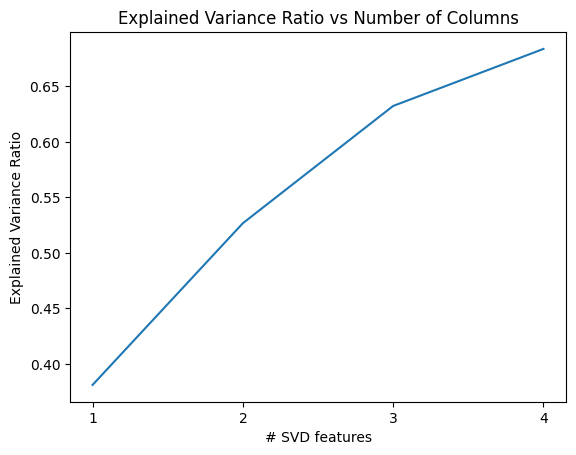

In [51]:
# plot of variance explained by svd features
cumulative_variance = np.cumsum(pca_dmr.explained_variance_ratio_) # variance covered by 4 components
plt.plot(range(1, len(cumulative_variance)+1), cumulative_variance)
plt.xticks(range(1,len(cumulative_variance)+1, 1))
plt.xlabel('# SVD features')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance Ratio vs Number of Columns')
plt.show()


In [52]:
magnitude = norm(df_pca.iloc[0,:])  #after SVD each post's tfidf vector is no longer normalized; 
print(f"The magnitude of the first row is {magnitude:.2f}") # important since the cosine similarity is the dot product of unit vectors

The magnitude of the first row is 13.56


In [53]:
# Normalizing the PCA output
pca_norm = normalize(df_pca)
df_pca_norm = pd.DataFrame(data=pca_norm,
                            index=df_pca.index)
df_pca_norm.head()

,0,1,2,3
training_id,,,,
hc_101,-0.908406,-0.203043,-0.322143,-0.172613
hc_112,-0.976532,0.039970,-0.204842,0.053167
hc_113,-0.913358,-0.214354,-0.322676,-0.125338
hc_115,-0.880059,-0.166975,-0.323395,-0.305008
hc_116,-0.900916,0.085199,-0.237685,-0.352983


In [54]:
magnitude = norm(df_pca_norm.iloc[0,:])
print(f"The magnitude of the first row is {magnitude:.2f}")

The magnitude of the first row is 1.00


In [55]:
# logarithm of number of participants for min_samples keyword argument
np.log(166)

5.111987788356544

In [56]:
# number of participants
df.training_id.nunique()

166

#### DBSCAN

We use the DBSCAN algorithm to cluster participants. DBSCAN stands for density based spatial clustering for applications with noise. This clustering algorithm is useful for clustering arbitarily shaped clusters. In DBSCAN a cluster is defined as a high density area.  Clusters are separated from one another by low density areas. The DBSCAN takes a distance measure, a minimum distance argument (eps) and a min_samples argument. This means a cluster is started by a point that has min_sample data points within eps distance of it. 

For text applications, cosine similarity is usually used as a similarity measure. Cosine similarity is the cosine of the angle between two unit vectors. Since cosine similarity is a similarity measure not a distance measure, two points that are the same have a similarity score of 1. A corresponding distance measure is the cosine distance which is 1 - cosine_similarity. This distance measure will thus have the distance between two identical points to be 0.

Cosine distance is specified in the DBSCAN object by setting the metric as 'cosine'. By setting an eps value of 0.1, and min_samples of 5 we essentially saying a cluster is started when a point is a cosine distance of 0.1 (or cosine similarity of 0.9) from 5 other points. The value of 5 is chosen as the natural log of the number of participants which is 166.

Because cosine similarity is defined for unit vectors, its important that the inputs of the DBSCAN be unit vectors.
As a result, we normalize the each participant's vector in the pca matrix before clustering. This normalization step can be seen as a data preparation step to using cosine distance.

In [57]:
# Clustering  with DBSCAN
cluster_model_bow = DBSCAN(eps=0.1, min_samples=5, metric='cosine') # initiaize with cosine distance,
clusters_bow = cluster_model_bow.fit_predict(df_pca_norm)

In [58]:
# cluster labels
clusters_bow

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  1,  2, -1,  0,  0,  0, -1,  2,  2,  0,  0,
        0,  0,  0,  2,  0,  0,  0,  0,  2,  0,  0,  2,  0,  0,  0,  0, -1,
        2,  3,  2,  0, -1,  0,  2,  0,  0,  0,  3,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  3,  0,  0,  0,  3,  2,  2,  0,
        2,  0,  2, -1,  2,  2,  0,  0,  2,  0,  1,  2,  0,  0,  0,  0,  0,
        2,  0,  0,  0,  2,  0,  0, -1,  2,  1,  0,  0,  0,  0,  2,  0,  0,
        0,  0, -1,  2,  0,  0,  0,  0,  2,  3, -1,  2,  0,  0,  2, -1, -1,
        0,  2,  0,  2,  0,  1,  0,  2,  2, -1,  2,  2,  2,  2,  2,  1, -1,
        2,  0,  2,  2,  0,  2,  2,  2,  0,  0,  2,  0,  0])

In [59]:
# 4 clusters and outlier label
np.unique(clusters_bow)

array([-1,  0,  1,  2,  3])

In [60]:
# value counts for each label
cluster_sizes = pd.DataFrame(clusters_bow).value_counts()
cluster_sizes

 0    103
 2     41
-1     12
 1      5
 3      5
Name: count, dtype: int64

In [61]:
# min points for dbscan suggested by theory
np.log(166)

5.111987788356544

In [62]:
# add cluster labels to command history dataframe
df_cmd_hist['clusters_bow'] = clusters_bow
df_cmd_hist.head()

,cmd,cmd_tool,cmd_args,clusters_bow
training_id,,,,
hc_101,"[nmap -sV, nmap --help, nmap -sV 172.18.1.5, n...","[nmap, nmap, nmap, nmap, search, set, set, use...","[-sv, --help, -sv 172.18.1.5, --help, libssh, ...",0
hc_112,"[nmap -sP 192.168.0.0-100, ifconfig, nmap --he...","[nmap, ifconfig, nmap, nmap, nmap, nmap, nmap,...","[-sp 192.168.0.0-100, , --help, 172.18.1.5, --...",0
hc_113,"[nmap -p 1-1000 172.18.1.5, libssh -h, nmap -p...","[nmap, libssh, nmap, sshlib, sudo, nmap, nmap,...","[-p 1-1000 172.18.1.5, -h, -p 1-56000 172.18.1...",0
hc_115,"[libssh, ssh, ssh -p, ssh --p, ssh -p -w, nmap...","[libssh, ssh, ssh, ssh, ssh, nmap, msfconsole,...","[, , -p, --p, -p -w, -sv, , postgresql start, ...",0
hc_116,"[nmap 172.18.1.5, ping 172.18.1.5, db_nmap -v ...","[nmap, ping, db, mfconsole, mfsconsole, msfcon...","[172.18.1.5, 172.18.1.5, nmap -v -sv 172.18.1....",0


In [63]:
# original columns
df.columns

Index(['training', 'cmd_type', 'pool_id', 'sandbox_id', 'timestamp_str',
       'hostname', 'cmd', 'username', 'wd', 'ip', 'training_id', 'tags',
       'timestamp_dt', 'cmd_split', 'cmd_tool', 'cmd_args'],
      dtype='object')

In [64]:
# size of the original bag of words vocabulary
len(bow_vectorizer.get_feature_names_out())

477

In [65]:
# use regex to match the possible delimiters separating tool from arguments
(df.cmd.str.split(r'[\s*/./-=:_]')).sample(13)  # the first value after regex split is likely cmd tool

9190                                       [show, options]
13277                     [set, RHOST, , , , , , , , , , ]
7621                                             [exploit]
13543                   [nmap, -v, -A, , , , , , , , , , ]
9168                                           [ls, , ssh]
5613                            [chmod, , , , , , id, rsa]
14107                                                 [ls]
4592     [searchsploit, -m, linux, remote, , , , , , , rb]
12937                                 [nano, Y, , yb, , h]
10084                    [nmap, -sS, , , , , , , , , , , ]
9632          [nmap, , , , , , , , , , , , --script, vuln]
6878                                            [cd, , , ]
142                                                  [run]
Name: cmd, dtype: object

In [66]:
# number of unique virtual sandboxes in secret laboratory game
df_sl.sandbox_id.nunique()

13

In [67]:
# number of unique virtual sandboxes in webmin exploit game
df_wb.sandbox_id.nunique()

10

In [68]:
# number of unique virtual sandboxes in house of cards game
df_hc.sandbox_id.nunique()

22

In [69]:
# number of unique virtual sandboxes in locusts 3302 game
df_lc.sandbox_id.nunique()

121

In [70]:
def cluster_to_image(df_cluster, cluster_id):
    words_to_score = {word: score 
        for word, score in df_cluster.items()   # create cloud dict
        if score != 0}        # if some words values are 0, dont add to cloud dict, skip
    cloud_generator = WordCloud(background_color='white',       # set background to white default is black
                                random_state=0)      # initialize cloud generator with random_state 
    wordcloud_image = cloud_generator.fit_words(words_to_score) # cloud dict into cloud generator for image
    plt.imshow(wordcloud_image, interpolation='bilinear')           # visualize cloud image
    plt.title(f"Cluster {cluster_id}")           
    plt.xticks([])                                               # remove the xticks
    plt.yticks([])   
    plt.show()

In [71]:
# top 10 tool names of cluster 0 by term frequency per participant
cluster0_indexes = (df_cmd_hist[df_cmd_hist.clusters_bow == 0]).index
df_cluster0_top10 = df_bow[df_bow.index.isin(cluster0_indexes)].sum(axis=0
            ).sort_values(ascending=False)[:10] / cluster_sizes[0]
df_cluster0_top10

set           8.320388
nmap          6.572816
ssh           3.087379
use           3.077670
exploit       3.038835
show          2.805825
run           2.563107
ls            2.543689
search        2.417476
msfconsole    2.126214
dtype: float64

In [72]:
for val in df_cluster0_top10.items():
    print(val)

('set', 8.320388349514563)
('nmap', 6.572815533980583)
('ssh', 3.087378640776699)
('use', 3.0776699029126213)
('exploit', 3.0388349514563107)
('show', 2.8058252427184467)
('run', 2.563106796116505)
('ls', 2.5436893203883497)
('search', 2.4174757281553396)
('msfconsole', 2.1262135922330097)


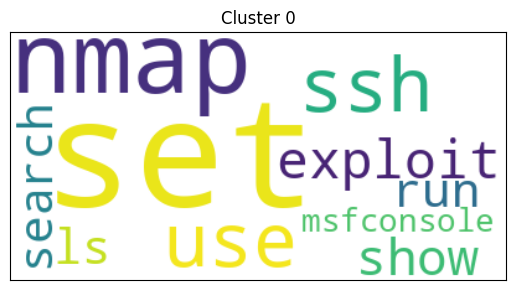

In [73]:
# Visualize top words of cluster 0
cluster_to_image(df_cluster0_top10, 0)

In [74]:
# top 10 tool names of cluster 1 by term frequency per participant
cluster1_indexes = (df_cmd_hist[df_cmd_hist.clusters_bow == 1]).index
df_cluster1_top10 = df_bow[df_bow.index.isin(cluster1_indexes)].sum(axis=0
                    ).sort_values(ascending=False)[:10] / cluster_sizes[1]
df_cluster1_top10

nmap    13.8
john    13.8
ls      10.4
cd       6.6
cat      6.6
nc       5.6
ssh      4.2
less     3.8
set      3.0
         2.8
dtype: float64

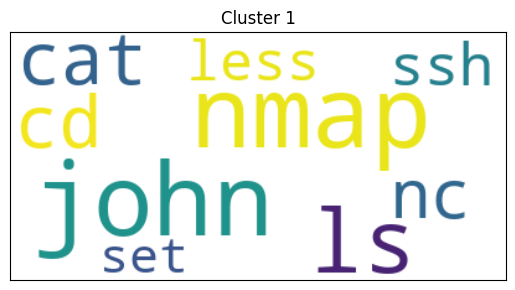

In [75]:
# Visualize top words of cluster 1
cluster_to_image(df_cluster1_top10, 1)

In [76]:
# top 10 tool names of cluster 2 by term frequency per participant
cluster2_indexes = (df_cmd_hist[df_cmd_hist.clusters_bow == 2]).index
df_cluster2_top10 = df_bow[df_bow.index.isin(cluster2_indexes)].sum(axis=0
                        ).sort_values(ascending=False)[:10] / cluster_sizes[2]
df_cluster2_top10

ls         23.170732
cd         16.414634
cat         8.170732
nmap        6.365854
set         6.073171
ssh         5.780488
john        3.268293
use         3.073171
show        2.853659
exploit     2.682927
dtype: float64

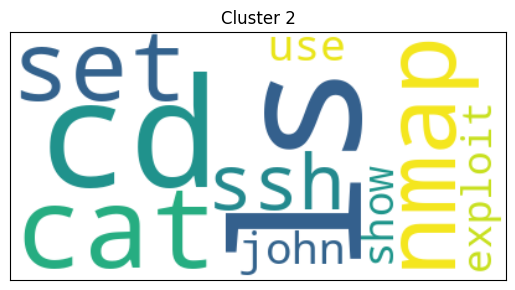

In [77]:
# Visualize top words of cluster 2
cluster_to_image(df_cluster2_top10,2)

In [78]:
# top 10 tool names of cluster 3 by term frequency per participant
cluster3_indexes = (df_cmd_hist[df_cmd_hist.clusters_bow == 3]).index
df_cluster3_top10 = (df_bow[df_bow.index.isin(cluster3_indexes)]).sum(axis=0
                    ).sort_values(ascending=False)[:15] / cluster_sizes[3]
df_cluster3_top10

python     47.4
ls         10.6
nmap        7.2
curl        5.8
vim         4.0
nano        3.8
set         3.6
ssh         3.2
cd          3.2
cat         2.8
exploit     2.6
run         2.4
module      2.4
use         2.2
nc          2.2
dtype: float64

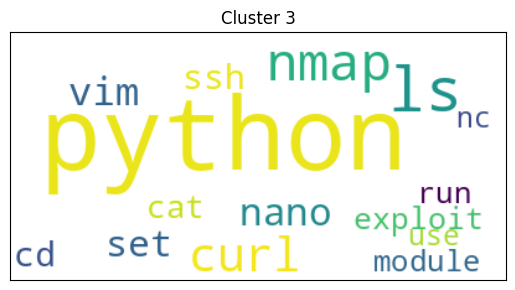

In [79]:
# Visualize top words of cluster 3
cluster_to_image(df_cluster3_top10,3)

In [80]:
# top 10 tool names of outliers by term frequency per participant
cluster_out_indexes = (df_cmd_hist[df_cmd_hist.clusters_bow == -1]).index
df_cluster_outlier_top10 =  df_bow[df_bow.index.isin(cluster_out_indexes)].sum(axis=0
                           ).sort_values(ascending=False)[:10]/  cluster_sizes[-1]
df_cluster_outlier_top10

set        14.750000
ls         13.750000
john       11.250000
nmap        9.333333
python      7.500000
cd          7.250000
show        6.333333
use         5.500000
exploit     4.750000
search      4.333333
dtype: float64

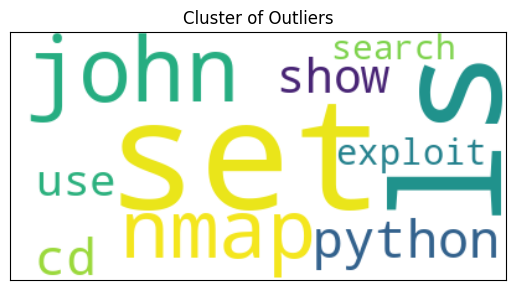

In [81]:
# Visualize top words of outliers
cluster_to_image(df_cluster_outlier_top10,'of Outliers')

In [82]:
cluster_sizes

 0    103
 2     41
-1     12
 1      5
 3      5
Name: count, dtype: int64

#### Bag of Words Model Clustering Analysis

When clustering the 166 trainees from Training A, 103 trainees form Cluster 0, 5 trainees constitute Cluster 1, 41 trainees form Cluster 2, 5 trainees form Cluster 3 and 12 were designated as outliers. 


Cluster 0 trainees mainly used cybersecurity commands (set, nmap, ssh, use and exploit) more often than other tool names. The cybersecurity commands were used 3-8 times on average by cluster 0 trainees.

set           8.320388 
nmap          6.572816
ssh           3.087379
use           3.077670
exploit       3.038835


Cluster 1 trainees used cybersecurity commands (nmap, john) 13 times on average, which is more than cluster 0 trainees, 3-8 times on average. This may be because cluster 1 trainees explored using the cybersecurity tools with more options. Cluster 1 trainees also used directory commands (cd ,ls ,cat) 6-10 times on average to find files.

nmap    13.8
john    13.8
ls      10.4
cd       6.6
cat      6.6


Cluster 2 trainees used directory commands (ls, cd, cat) 8-23 times, which is overwhelmingly more than the other clusters. They probably had trouble locating the files crucial for the task. Based on this insight, instructors can again provide targeted help to trainees in this cluster. 


ls         23.170732
cd         16.414634
cat         8.170732
nmap        6.365854
set         6.073171


Cluster 3 trainiees used file reading commands (python, curl, vim) more often than the other clusters did. Cluster 3 trainees used vim and curl 4-6 times on average and used python a surprising 47 times on average. These trainees likely typed up their commands in files instead of directly into the terminal application. This might suggest advanced skills or outside intervention. 

python          47.4
ls              10.6
nmap             7.2
curl             5.8
vim              4.0


The trainees designated as outliers show a mix of the tools preferred used by other clusters. The top tools include cybersecurity tools (set, john, nmap), directory commands (ls), and file reading commands (python). These tools were used a modest amount of 7-14 times.

set        14.750000
ls         13.750000
john       11.250000
nmap        9.333333
python      7.500000



### Matrix of Selected Features 

#### Data Preparation

V. Švábenský, J. Vykopal, P. Čeleda, K. Tkáčik, and D. Popovič: Student Assessment in Cybersecurity Training Automated by Pattern Mining and Clustering, Springer Education and Information Technologies, 2022, ISSN 1360-2357

While the bag of words model captures the used commands, it does not consider other information available in the logs. Therefore, we selected five custom features to capture other insights into how the trainees progressed:

• bash-count, the number of submitted Bash commands. A small number may suggest that a trainee did not progress far in training. The high number may indicate using a trial and error approach.

• msf-count, the number of Metasploit commands a trainee used. Metasploit may be new for some trainees, and the high number of executed commands may indicate difficulties with this part of the training.

• avg-gap, the average delay between two commands. Large gaps between commands may suggest the trainee did not understand how to use a tool and possibly looked for the information online. Small delays may indicate brute-force guessing.

• opt-changes, the number of times trainee used the same tool twice in a row but changed the options or arguments. A high count may show the trainee’s unfamiliarity with the tool or inability to use it.

• help-count, the number of times trainee displayed help information or manual page for any tool. It may also indicate the trainees’ unfamiliarity with the tool.


#### Feature Engineering

help-count:  can be obtained from the bag of words matrix. This means we are assuming that help is a tool name and not an argument, since the bag of words matrix created earlier, only considered tool names.

msf-count : for rows where application type is msf-command, just aggregate by training id and count the number of rows of each training id sub dataframe. This will use the original dataframe.

bash-count :  for rows where application type is bash-command, just aggregate by training id and count the number of rows of each training id sub dataframe. This will use the original dataframe.

avg-gap . first group by training id and for each sub dataframe, sort by timestamp_dt. Then use shift() on the subdataframes to create lag dataframe to allow for vectorized solution. Gap value in seconds was computed for each command by subtracting the timestamp_dt for the original and lag dataframes. Then, gaps exceeding the arbitrary maximum of 20 minutes were removed before the average gap is calculated for each training id. This can be done using .apply() and passing a custom function.

opt-changes . This will use the original dataframe. For every training_id, we sort by timestamp_dt. Then in another application of shift() we lag the data for rolling window style comparison. We create a mask which is true if the command tool is the same but the arguments differ for the same index between the original and lag dataframes. This can be done using .apply() and applying a custom function after grouping the original dataframe by training_id.

concatenate these tiny dataframes along training_id to create the matrix of selected features [index = training_id, columns = help_count, msf_count, bash_count, avg_gap, opt_changes]



In [83]:
# original dataframe columns
df.columns

Index(['training', 'cmd_type', 'pool_id', 'sandbox_id', 'timestamp_str',
       'hostname', 'cmd', 'username', 'wd', 'ip', 'training_id', 'tags',
       'timestamp_dt', 'cmd_split', 'cmd_tool', 'cmd_args'],
      dtype='object')

In [84]:
# tool names with 'help' in it
help_columns = df_bow.columns[df_bow.columns.str.lower().str.contains('help')]
help_columns = help_columns.tolist()
help_columns

['--help', '-help', 'help']

In [85]:
# bow matrix with just the help related tool names
df_help = df_bow[help_columns].copy()
df_help

,--help,-help,help
training_id,,,
hc_101,0,0,1
hc_112,0,0,0
hc_113,0,0,0
hc_115,0,0,0
hc_116,0,0,0
...,...,...,...
wb_329,0,0,0
wb_331,0,0,1
wb_351,0,0,0


In [86]:
# Help page count
df_help_count = df_help.sum(axis=1)
df_help_count.name = 'help_count'
df_help_count

training_id
hc_101    1
hc_112    0
hc_113    0
hc_115    0
hc_116    0
         ..
wb_329    0
wb_331    1
wb_351    0
wb_358    2
wb_374    1
Name: help_count, Length: 166, dtype: int64

In [87]:
# unique help count values
df_help_count.unique()

array([ 1,  0,  2, 10,  3,  4])

Text(0.5, 1.0, 'Distribution of help page count')

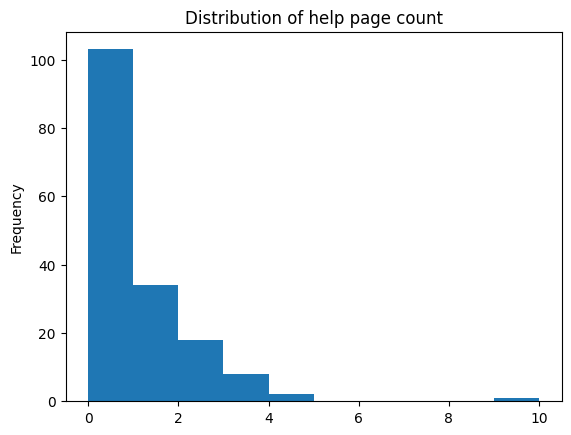

In [88]:
# Distribution of help page count
df_help_count.plot.hist()
plt.title('Distribution of help page count')

In [89]:
# number of bash command
(df[df.cmd_type == 'bash-command']).shape

(9637, 16)

In [90]:
# number of metasploit command
(df[df.cmd_type == 'msf-command']).shape

(5025, 16)

In [91]:
# metasploit command dataframe
df[df.cmd_type == 'msf-command']

,training,cmd_type,pool_id,sandbox_id,timestamp_str,hostname,cmd,username,wd,ip,training_id,tags,timestamp_dt,cmd_split,cmd_tool,cmd_args
4,House of cards,msf-command,0,93,2019-12-08 14:44:16.001640+00:00,attacker,back,NaN,NaN,10.0.135.83,hc_93,NaN,2019-12-08 14:44:16.001640+00:00,[back],back,
5,House of cards,msf-command,0,93,2019-12-08 14:45:29.397084+00:00,attacker,exit,NaN,NaN,10.0.135.83,hc_93,NaN,2019-12-08 14:45:29.397084+00:00,[exit],exit,
7,House of cards,msf-command,0,93,2019-12-08 14:46:39.149326+00:00,attacker,exit,NaN,NaN,10.0.135.83,hc_93,NaN,2019-12-08 14:46:39.149326+00:00,[exit],exit,
8,House of cards,msf-command,0,93,2019-12-08 14:47:07.019673+00:00,attacker,back,NaN,NaN,10.0.135.83,hc_93,NaN,2019-12-08 14:47:07.019673+00:00,[back],back,
40,House of cards,msf-command,0,93,2019-12-08 20:11:51.187615+00:00,attacker,options,NaN,NaN,10.0.135.83,hc_93,NaN,2019-12-08 20:11:51.187615+00:00,[options],options,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14655,Webmin exploit practice,msf-command,1,374,2020-05-14 11:20:45.479996+02:00,attacker,use exploit/unix/webapp/webmin_upload_exec,NaN,NaN,10.1.135.83,wb_374,NaN,2020-05-14 09:20:45.479996+00:00,"[use, exploit/unix/webapp/webmin_upload_exec]",use,exploit/unix/webapp/webmin_upload_exec
14656,Webmin exploit practice,msf-command,1,374,2020-05-14 11:22:52.136027+02:00,attacker,exit,NaN,NaN,10.1.135.83,wb_374,NaN,2020-05-14 09:22:52.136027+00:00,[exit],exit,
14658,Webmin exploit practice,msf-command,1,374,2020-05-14 11:23:53.519029+02:00,attacker,use exploit/unix/webapp/webmin_upload_exec > s...,NaN,NaN,10.1.135.83,wb_374,NaN,2020-05-14 09:23:53.519029+00:00,"[use, exploit/unix/webapp/webmin_upload_exec >...",use,exploit/unix/webapp/webmin_upload_exec > set l...
14659,Webmin exploit practice,msf-command,1,374,2020-05-14 11:24:16.022195+02:00,attacker,exploit,NaN,NaN,10.1.135.83,wb_374,NaN,2020-05-14 09:24:16.022195+00:00,[exploit],exploit,


In [92]:
# Metasploit commands by each participant
df_msf_count = (df[df.cmd_type == 'msf-command']).groupby('training_id').size()
df_msf_count.name = 'msf_count'
df_msf_count

training_id
hc_101    14
hc_112    29
hc_113     7
hc_115    11
hc_116    19
          ..
wb_329    10
wb_331    24
wb_351    15
wb_358    43
wb_374    14
Name: msf_count, Length: 158, dtype: int64

In [93]:
# intermediate matrix of selected features
pd.concat([df_help_count, df_msf_count],axis=1)

,help_count,msf_count
training_id,,
hc_101,1,14.0
hc_112,0,29.0
hc_113,0,7.0
hc_115,0,11.0
hc_116,0,19.0
...,...,...
wb_329,0,10.0
wb_331,1,24.0
wb_351,0,15.0


Text(0.5, 1.0, 'Distribution of metasploit command count')

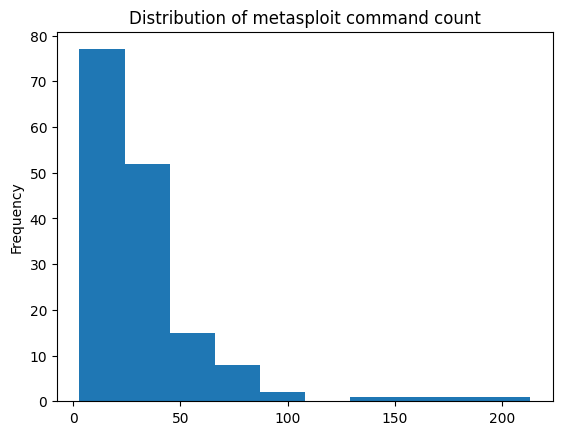

In [94]:
df_msf_count.plot.hist()
plt.title('Distribution of metasploit command count')

In [95]:
df_bash_count = (df[df.cmd_type == 'bash-command']).groupby('training_id').size()
df_bash_count.name  = 'bash_count'
df_bash_count

training_id
hc_101      6
hc_112     31
hc_113     15
hc_115     13
hc_116     18
         ... 
wb_329     43
wb_331     41
wb_351    152
wb_358     21
wb_374     21
Name: bash_count, Length: 166, dtype: int64

Text(0.5, 1.0, 'Distribution of bash command count')

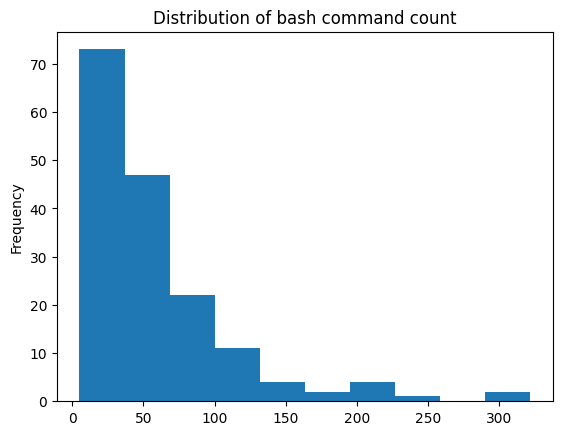

In [96]:
# Distribution of bash-count values
df_bash_count.plot.hist()
plt.title('Distribution of bash command count')

In [97]:
# intermediate matrix of selected features
pd.concat([df_help_count, df_msf_count, df_bash_count], axis=1)

,help_count,msf_count,bash_count
training_id,,,
hc_101,1,14.0,6
hc_112,0,29.0,31
hc_113,0,7.0,15
hc_115,0,11.0,13
hc_116,0,19.0,18
...,...,...,...
wb_329,0,10.0,43
wb_331,1,24.0,41
wb_351,0,15.0,152


In [98]:
# exploring timestamp_dt for a single participant, training_id = 'hc_101'
df_hc101 = df[df.training_id == 'hc_101']
df_hc101 = df_hc101.sort_values(by='timestamp_dt')
#df_hc101 = df_hc101.set_index('timestamp_dt')
df_hc101.tail()

,training,cmd_type,pool_id,sandbox_id,timestamp_str,hostname,cmd,username,wd,ip,training_id,tags,timestamp_dt,cmd_split,cmd_tool,cmd_args
144,House of cards,msf-command,0,101,2019-09-26 09:43:24.700135+00:00,attacker,run,NaN,NaN,10.0.135.83,hc_101,NaN,2019-09-26 09:43:24.700135+00:00,[run],run,
145,House of cards,msf-command,0,101,2019-09-26 09:44:17.207070+00:00,attacker,exit,NaN,NaN,10.0.135.83,hc_101,NaN,2019-09-26 09:44:17.207070+00:00,[exit],exit,
146,House of cards,msf-command,0,101,2019-09-26 09:44:34.266437+00:00,attacker,exit -y,NaN,NaN,10.0.135.83,hc_101,NaN,2019-09-26 09:44:34.266437+00:00,"[exit, -y]",exit,-y
147,House of cards,bash-command,0,101,2019-09-26 09:45:01.059273+00:00,attacker,ssh 172.18.1.5,root,/root,10.0.135.83,hc_101,NaN,2019-09-26 09:45:01.059273+00:00,"[ssh, 172.18.1.5]",ssh,172.18.1.5
148,House of cards,bash-command,0,101,2019-09-26 09:45:21.121167+00:00,attacker,ssh alice@172.18.1.5,root,/root,10.0.135.83,hc_101,NaN,2019-09-26 09:45:21.121167+00:00,"[ssh, alice@172.18.1.5]",ssh,alice@172.18.1.5


In [99]:
df_hc101.shift(1).head()

,training,cmd_type,pool_id,sandbox_id,timestamp_str,hostname,cmd,username,wd,ip,training_id,tags,timestamp_dt,cmd_split,cmd_tool,cmd_args
129,None,None,NaN,NaN,None,None,None,None,None,None,None,None,NaT,None,None,None
130,House of cards,bash-command,0.0,101.0,2019-09-26 09:23:29.156399+00:00,attacker,nmap -sV,root,/root,10.0.135.83,hc_101,NaN,2019-09-26 09:23:29.156399+00:00,"[nmap, -sV]",nmap,-sv
131,House of cards,bash-command,0.0,101.0,2019-09-26 09:23:53.451916+00:00,attacker,nmap --help,root,/root,10.0.135.83,hc_101,NaN,2019-09-26 09:23:53.451916+00:00,"[nmap, --help]",nmap,--help
132,House of cards,bash-command,0.0,101.0,2019-09-26 09:24:40.283127+00:00,attacker,nmap -sV 172.18.1.5,root,/root,10.0.135.83,hc_101,NaN,2019-09-26 09:24:40.283127+00:00,"[nmap, -sV 172.18.1.5]",nmap,-sv 172.18.1.5
133,House of cards,bash-command,0.0,101.0,2019-09-26 09:31:56.239241+00:00,attacker,nmap --help,root,/root,10.0.135.83,hc_101,NaN,2019-09-26 09:31:56.239241+00:00,"[nmap, --help]",nmap,--help


In [100]:
# calculating the gap time for every command by training_id = 'hc_101'
df_hc101['timestamp_dt'] - (df_hc101.shift(1))['timestamp_dt']

129                      NaT
130   0 days 00:00:24.295517
131   0 days 00:00:46.831211
132   0 days 00:07:15.956114
133   0 days 00:05:01.959951
134   0 days 00:00:57.175729
135   0 days 00:00:09.494495
136   0 days 00:00:58.366101
137   0 days 00:00:03.519992
138   0 days 00:00:12.871254
139   0 days 00:00:07.115559
140   0 days 00:00:01.777485
141   0 days 00:00:30.664779
142   0 days 00:02:03.954759
143   0 days 00:01:17.696638
144   0 days 00:00:03.864152
145   0 days 00:00:52.506935
146   0 days 00:00:17.059367
147   0 days 00:00:26.792836
148   0 days 00:00:20.061894
Name: timestamp_dt, dtype: timedelta64[ns]

In [101]:
# calculating the average gap for training_id = 'hc_101'
(df_hc101['timestamp_dt'] - (df_hc101.shift(1))['timestamp_dt']).mean()

Timedelta('0 days 00:01:09.050777263')

In [102]:
def avg_gap_func(x): # x is a dataframe
    x = x.sort_values(by='timestamp_dt') # sort by timestamp_dt so shift() lags data correctly
    gap_values =  x['timestamp_dt'] - (x.shift(1))['timestamp_dt'] # lag using shift(1)
    gap_values = gap_values[gap_values < timedelta(minutes=20)] # remove technical difficulty delays
    avg_gap = gap_values.mean()     # average gap value; avg_gap is a timedelta object
    avg_gap_sec = avg_gap.total_seconds()  # timedelta object conversion to seconds method, total_seconds()
    return np.round(avg_gap_sec, 0)   

df_avg_gap = df.groupby('training_id').apply(avg_gap_func)
df_avg_gap.name = 'avg_gap'
df_avg_gap

training_id
hc_101     69.0
hc_112     97.0
hc_113    122.0
hc_115    178.0
hc_116     80.0
          ...  
wb_329     54.0
wb_331     89.0
wb_351     45.0
wb_358     98.0
wb_374     90.0
Name: avg_gap, Length: 166, dtype: float64

Text(0.5, 1.0, 'Distribution of average gap in seconds')

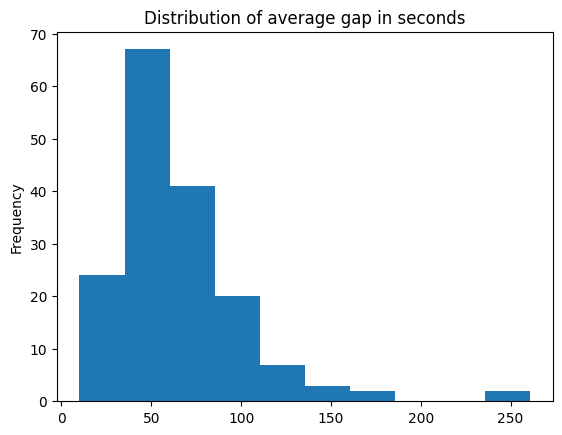

In [103]:
# Distribution of bash-count values
df_avg_gap.plot.hist()
plt.title('Distribution of average gap in seconds')

In [104]:
# intermediate matrix of selected features
pd.concat([df_help_count, df_msf_count,df_bash_count, df_avg_gap],axis=1)

,help_count,msf_count,bash_count,avg_gap
training_id,,,,
hc_101,1,14.0,6,69.0
hc_112,0,29.0,31,97.0
hc_113,0,7.0,15,122.0
hc_115,0,11.0,13,178.0
hc_116,0,19.0,18,80.0
...,...,...,...,...
wb_329,0,10.0,43,54.0
wb_331,1,24.0,41,89.0
wb_351,0,15.0,152,45.0


In [105]:
# exploring timestamp_dt for a single participant, training_id = 'hc_101'
df_hc101 = df[df.training_id == 'hc_101']
df_hc101 = df_hc101.sort_values(by='timestamp_dt')
df_hc101_s = df_hc101.shift(1)

In [106]:
# individual hc101 original dataframe
df_hc101.head()

,training,cmd_type,pool_id,sandbox_id,timestamp_str,hostname,cmd,username,wd,ip,training_id,tags,timestamp_dt,cmd_split,cmd_tool,cmd_args
129,House of cards,bash-command,0,101,2019-09-26 09:23:29.156399+00:00,attacker,nmap -sV,root,/root,10.0.135.83,hc_101,NaN,2019-09-26 09:23:29.156399+00:00,"[nmap, -sV]",nmap,-sv
130,House of cards,bash-command,0,101,2019-09-26 09:23:53.451916+00:00,attacker,nmap --help,root,/root,10.0.135.83,hc_101,NaN,2019-09-26 09:23:53.451916+00:00,"[nmap, --help]",nmap,--help
131,House of cards,bash-command,0,101,2019-09-26 09:24:40.283127+00:00,attacker,nmap -sV 172.18.1.5,root,/root,10.0.135.83,hc_101,NaN,2019-09-26 09:24:40.283127+00:00,"[nmap, -sV 172.18.1.5]",nmap,-sv 172.18.1.5
132,House of cards,bash-command,0,101,2019-09-26 09:31:56.239241+00:00,attacker,nmap --help,root,/root,10.0.135.83,hc_101,NaN,2019-09-26 09:31:56.239241+00:00,"[nmap, --help]",nmap,--help
133,House of cards,msf-command,0,101,2019-09-26 09:36:58.199192+00:00,attacker,search libssh,NaN,NaN,10.0.135.83,hc_101,NaN,2019-09-26 09:36:58.199192+00:00,"[search, libssh]",search,libssh


In [107]:
# individual hc101 shifted dataframe
df_hc101_s.head()

,training,cmd_type,pool_id,sandbox_id,timestamp_str,hostname,cmd,username,wd,ip,training_id,tags,timestamp_dt,cmd_split,cmd_tool,cmd_args
129,None,None,NaN,NaN,None,None,None,None,None,None,None,None,NaT,None,None,None
130,House of cards,bash-command,0.0,101.0,2019-09-26 09:23:29.156399+00:00,attacker,nmap -sV,root,/root,10.0.135.83,hc_101,NaN,2019-09-26 09:23:29.156399+00:00,"[nmap, -sV]",nmap,-sv
131,House of cards,bash-command,0.0,101.0,2019-09-26 09:23:53.451916+00:00,attacker,nmap --help,root,/root,10.0.135.83,hc_101,NaN,2019-09-26 09:23:53.451916+00:00,"[nmap, --help]",nmap,--help
132,House of cards,bash-command,0.0,101.0,2019-09-26 09:24:40.283127+00:00,attacker,nmap -sV 172.18.1.5,root,/root,10.0.135.83,hc_101,NaN,2019-09-26 09:24:40.283127+00:00,"[nmap, -sV 172.18.1.5]",nmap,-sv 172.18.1.5
133,House of cards,bash-command,0.0,101.0,2019-09-26 09:31:56.239241+00:00,attacker,nmap --help,root,/root,10.0.135.83,hc_101,NaN,2019-09-26 09:31:56.239241+00:00,"[nmap, --help]",nmap,--help


In [108]:
# rolling window implementation by comparing origianl versus shifted dataframe
shifted = df_hc101[(df_hc101.cmd_tool == df_hc101_s.cmd_tool) & (df_hc101.cmd_args != df_hc101_s.cmd_args)]
shifted

,training,cmd_type,pool_id,sandbox_id,timestamp_str,hostname,cmd,username,wd,ip,training_id,tags,timestamp_dt,cmd_split,cmd_tool,cmd_args
130,House of cards,bash-command,0,101,2019-09-26 09:23:53.451916+00:00,attacker,nmap --help,root,/root,10.0.135.83,hc_101,NaN,2019-09-26 09:23:53.451916+00:00,"[nmap, --help]",nmap,--help
131,House of cards,bash-command,0,101,2019-09-26 09:24:40.283127+00:00,attacker,nmap -sV 172.18.1.5,root,/root,10.0.135.83,hc_101,NaN,2019-09-26 09:24:40.283127+00:00,"[nmap, -sV 172.18.1.5]",nmap,-sv 172.18.1.5
132,House of cards,bash-command,0,101,2019-09-26 09:31:56.239241+00:00,attacker,nmap --help,root,/root,10.0.135.83,hc_101,NaN,2019-09-26 09:31:56.239241+00:00,"[nmap, --help]",nmap,--help
135,House of cards,msf-command,0,101,2019-09-26 09:38:04.869416+00:00,attacker,set RPORT 23,NaN,NaN,10.0.135.83,hc_101,NaN,2019-09-26 09:38:04.869416+00:00,"[set, RPORT 23]",set,rport 23
139,House of cards,msf-command,0,101,2019-09-26 09:39:26.742322+00:00,attacker,set RPORT 23,NaN,NaN,10.0.135.83,hc_101,NaN,2019-09-26 09:39:26.742322+00:00,"[set, RPORT 23]",set,rport 23
146,House of cards,msf-command,0,101,2019-09-26 09:44:34.266437+00:00,attacker,exit -y,NaN,NaN,10.0.135.83,hc_101,NaN,2019-09-26 09:44:34.266437+00:00,"[exit, -y]",exit,-y
148,House of cards,bash-command,0,101,2019-09-26 09:45:21.121167+00:00,attacker,ssh alice@172.18.1.5,root,/root,10.0.135.83,hc_101,NaN,2019-09-26 09:45:21.121167+00:00,"[ssh, alice@172.18.1.5]",ssh,alice@172.18.1.5


In [109]:
# function to engineer opt_changes as a feature
def opt_changes_func(x): # x is a dataframe
    x = x.sort_values(by='timestamp_dt') # sort by timestamp_dt so shift() lags data correctly
    lag_x = x.shift(1) # shift the data down one
    shifted = x[(x.cmd_tool == lag_x.cmd_tool) & (x.cmd_args != lag_x.cmd_args)]
    return shifted.shape[0]  

df_opt_changes = df.groupby('training_id').apply(opt_changes_func)
df_opt_changes.name = 'opt_changes'
df_opt_changes

training_id
hc_101     7
hc_112    18
hc_113     5
hc_115     9
hc_116     9
          ..
wb_329    19
wb_331    12
wb_351    34
wb_358    11
wb_374    11
Name: opt_changes, Length: 166, dtype: int64

Text(0.5, 1.0, 'Distribution of Option Changes')

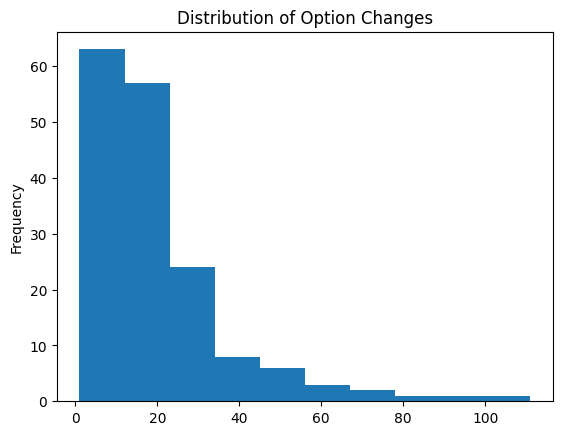

In [110]:
# Distribution of bash-count values
df_opt_changes.plot.hist()
plt.title('Distribution of Option Changes')

In [111]:
# intermediate matrix of selected features
pd.concat([df_help_count, df_msf_count,df_bash_count, df_avg_gap, df_opt_changes],axis=1)

,help_count,msf_count,bash_count,avg_gap,opt_changes
training_id,,,,,
hc_101,1,14.0,6,69.0,7
hc_112,0,29.0,31,97.0,18
hc_113,0,7.0,15,122.0,5
hc_115,0,11.0,13,178.0,9
hc_116,0,19.0,18,80.0,9
...,...,...,...,...,...
wb_329,0,10.0,43,54.0,19
wb_331,1,24.0,41,89.0,12
wb_351,0,15.0,152,45.0,34


In [112]:
# put all selected features together into a matrix
df_custom_feats = pd.concat([df_help_count, df_msf_count,df_bash_count, df_avg_gap, df_opt_changes],axis=1)
df_custom_feats.sample(7)

,help_count,msf_count,bash_count,avg_gap,opt_changes
training_id,,,,,
lc_644,0,15.0,16,88.0,6
hc_399,0,72.0,21,28.0,11
lc_43,0,63.0,55,64.0,13
lc_693,0,28.0,16,84.0,10
lc_101,1,11.0,86,35.0,34
hc_137,0,15.0,13,85.0,5
lc_59,0,12.0,60,49.0,32


In [113]:
# selected features are not highly correlated
df_custom_feats.corr()

,help_count,msf_count,bash_count,avg_gap,opt_changes
help_count,1.000000,0.075603,0.061574,-0.117726,0.082231
msf_count,0.075603,1.000000,0.207661,-0.391663,0.498557
bash_count,0.061574,0.207661,1.000000,-0.470243,0.650221
avg_gap,-0.117726,-0.391663,-0.470243,1.000000,-0.390005
opt_changes,0.082231,0.498557,0.650221,-0.390005,1.000000


In [114]:
# 8 participants did not use metasploit
df_custom_feats.describe()

,help_count,msf_count,bash_count,avg_gap,opt_changes
count,166.000000,158.000000,166.000000,166.000000,166.000000
mean,0.674699,31.803797,58.054217,65.861446,19.680723
std,1.191978,30.167570,54.493954,36.515818,16.926951
min,0.000000,3.000000,5.000000,10.000000,1.000000
25%,0.000000,14.000000,21.000000,43.250000,9.000000
50%,0.000000,24.000000,43.000000,58.500000,15.000000
75%,1.000000,37.500000,73.750000,80.000000,23.000000
max,10.000000,213.000000,322.000000,261.000000,111.000000


In [115]:
# fill NaN values with 0 for 0 count
df_custom_feats = df_custom_feats.fillna(0)
df_custom_feats.describe()

,help_count,msf_count,bash_count,avg_gap,opt_changes
count,166.000000,166.000000,166.000000,166.000000,166.000000
mean,0.674699,30.271084,58.054217,65.861446,19.680723
std,1.191978,30.209852,54.493954,36.515818,16.926951
min,0.000000,0.000000,5.000000,10.000000,1.000000
25%,0.000000,12.000000,21.000000,43.250000,9.000000
50%,0.000000,23.000000,43.000000,58.500000,15.000000
75%,1.000000,36.000000,73.750000,80.000000,23.000000
max,10.000000,213.000000,322.000000,261.000000,111.000000


#### Standardization / Normalization with Maximum Absolute Value Scaling

Here, since we dont have an abundance of columns we dont need a dimensionality reduction technique. However the columns need to be on the same scale so that no one column dominates the clustering analysis. All features were standardized, namely scaled by their maximum absolute value. This effectively limits the data into the range [-1,1] without losing outlier information or shifting the center of the data.

In [116]:
scaler = MaxAbsScaler()
custom_feat_scaled = scaler.fit_transform(df_custom_feats)
df_custom_scaled = pd.DataFrame(data=custom_feat_scaled,
                                columns = df_custom_feats.columns,
                                index = df_custom_feats.index)
df_custom_scaled

,help_count,msf_count,bash_count,avg_gap,opt_changes
training_id,,,,,
hc_101,0.1,0.065728,0.018634,0.264368,0.063063
hc_112,0.0,0.136150,0.096273,0.371648,0.162162
hc_113,0.0,0.032864,0.046584,0.467433,0.045045
hc_115,0.0,0.051643,0.040373,0.681992,0.081081
hc_116,0.0,0.089202,0.055901,0.306513,0.081081
...,...,...,...,...,...
wb_329,0.0,0.046948,0.133540,0.206897,0.171171
wb_331,0.1,0.112676,0.127329,0.340996,0.108108
wb_351,0.0,0.070423,0.472050,0.172414,0.306306


In [117]:
# magnitude of one participant vector 
# important since the cosine similarity is the dot product of unit vectors
magnitude = norm(df_custom_scaled.iloc[0,:])  # check vector length after maximum absolute scaling
print(f"The magnitude of the first row is {magnitude:.2f}") 


The magnitude of the first row is 0.30


In [118]:
# Normalizing the PCA output
custom_scaled_norm = normalize(df_custom_scaled)

In [119]:
#sanity check of shape after normalizing,
custom_scaled_norm.shape

(166, 5)

In [120]:
# dataframe with scaled normalized custom featuress
df_custom_scaled_norm = pd.DataFrame(data=custom_scaled_norm, 
                                     columns=df_custom_feats.columns, 
                                     index=df_custom_feats.index)
df_custom_scaled_norm

,help_count,msf_count,bash_count,avg_gap,opt_changes
training_id,,,,,
hc_101,0.336081,0.220898,0.062624,0.888489,0.211943
hc_112,0.000000,0.310538,0.219585,0.847671,0.369867
hc_113,0.000000,0.069473,0.098476,0.988134,0.095223
hc_115,0.000000,0.074854,0.058518,0.988514,0.117523
hc_116,0.000000,0.267011,0.167329,0.917497,0.242703
...,...,...,...,...,...
wb_329,0.000000,0.154664,0.439928,0.681588,0.563897
wb_331,0.244796,0.275827,0.311697,0.834747,0.264645
wb_351,0.000000,0.118809,0.796386,0.290876,0.516764


In [121]:
# important since the cosine similarity is defined as the dot product of unit vectors
magnitude = norm(df_custom_scaled_norm.iloc[0,:])  # check vector length after maximum absolute scaling
print(f"The magnitude of the first row is {magnitude:.2f}") 


The magnitude of the first row is 1.00


In [ ]:
# Clustering  with DBSCAN
cluster_model_sf = DBSCAN(eps=0.1, min_samples=5, metric='cosine') # initiaize with cosine distance,
clusters_dbs = cluster_model_sf.fit_predict(df_custom_scaled_norm)
clusters_dbs                                                        # cluster labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [123]:
# 4 clusters and outlier label
np.unique(clusters_dbs)


array([0])

In [124]:
# value counts for each label (there is a single cluster label)
pd.DataFrame(clusters_dbs).value_counts()

0    166
Name: count, dtype: int64

In [125]:
# every datapoint has cosine similarity of at least 0.9 (cosine distance of 0.1) with many other datapoints
pd.DataFrame(cosine_similarity(df_custom_scaled_norm,df_custom_scaled_norm),
             index=df_custom_scaled_norm.index,
             columns=df_custom_scaled_norm.index)

training_id,hc_101,hc_112,hc_113,hc_115,hc_116,hc_130,hc_131,hc_137,hc_144,hc_148,...,wb_315,wb_316,wb_317,wb_327,wb_328,wb_329,wb_331,wb_351,wb_358,wb_374
training_id,,,,,,,,,,,,,,,,,,,,,
hc_101,1.000000,0.913886,0.919641,0.923392,0.936086,0.968155,0.923694,0.936046,0.807348,0.932053,...,0.684040,0.905043,0.881376,0.792420,0.544596,0.786812,0.960473,0.444082,0.968907,0.989039
hc_112,0.913886,1.000000,0.916031,0.917498,0.987164,0.826735,0.837413,0.955152,0.912046,0.960152,...,0.843190,0.985206,0.975640,0.931972,0.753808,0.930961,0.959573,0.649470,0.889503,0.947599
hc_113,0.919641,0.916031,1.000000,0.998938,0.964749,0.836892,0.770684,0.989133,0.739440,0.990063,...,0.698763,0.939215,0.914160,0.802753,0.490892,0.781264,0.899899,0.423312,0.825582,0.941021
hc_115,0.923392,0.917498,0.998938,1.000000,0.965261,0.834525,0.770566,0.988820,0.744802,0.987930,...,0.684641,0.934839,0.908036,0.791804,0.478678,0.777352,0.895148,0.403763,0.827298,0.941252
hc_116,0.936086,0.987164,0.964749,0.965261,1.000000,0.846014,0.817350,0.990107,0.881486,0.990531,...,0.786297,0.981844,0.963406,0.891452,0.656821,0.877125,0.955913,0.557280,0.892429,0.961167
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
wb_329,0.786812,0.930961,0.781264,0.777352,0.877125,0.741879,0.840086,0.815095,0.789826,0.844347,...,0.969337,0.941984,0.962134,0.982378,0.908346,1.000000,0.897971,0.858387,0.765473,0.859227
wb_331,0.960473,0.959573,0.899899,0.895148,0.955913,0.938574,0.928948,0.932490,0.859868,0.941281,...,0.840927,0.963755,0.957263,0.921894,0.739922,0.897971,1.000000,0.660569,0.956798,0.982308
wb_351,0.444082,0.649470,0.423312,0.403763,0.557280,0.478921,0.630208,0.468121,0.543434,0.518584,...,0.940722,0.691718,0.745368,0.872549,0.971886,0.858387,0.660569,1.000000,0.486715,0.550448


#### K-Means

DBSCAN didnt return any clusters even at an eps=0.1 (cosine similarity of 0.9). A check of the cosine similarity between participant vectors reveal that indeed, the students have high cosine similarities with one another. So use a partitional algorithm like KMeans instead of a density based algorithm like DBSCAN. 

KMeans is sensitive to the scale of different features due to the use of euclidean distance. As such the scaled dataframe will be used. Because KMeans requires the number of centroids be specified, an elbow analysis will be done to select the optimal centroid number. The optimal centroid number was decided to be 5.

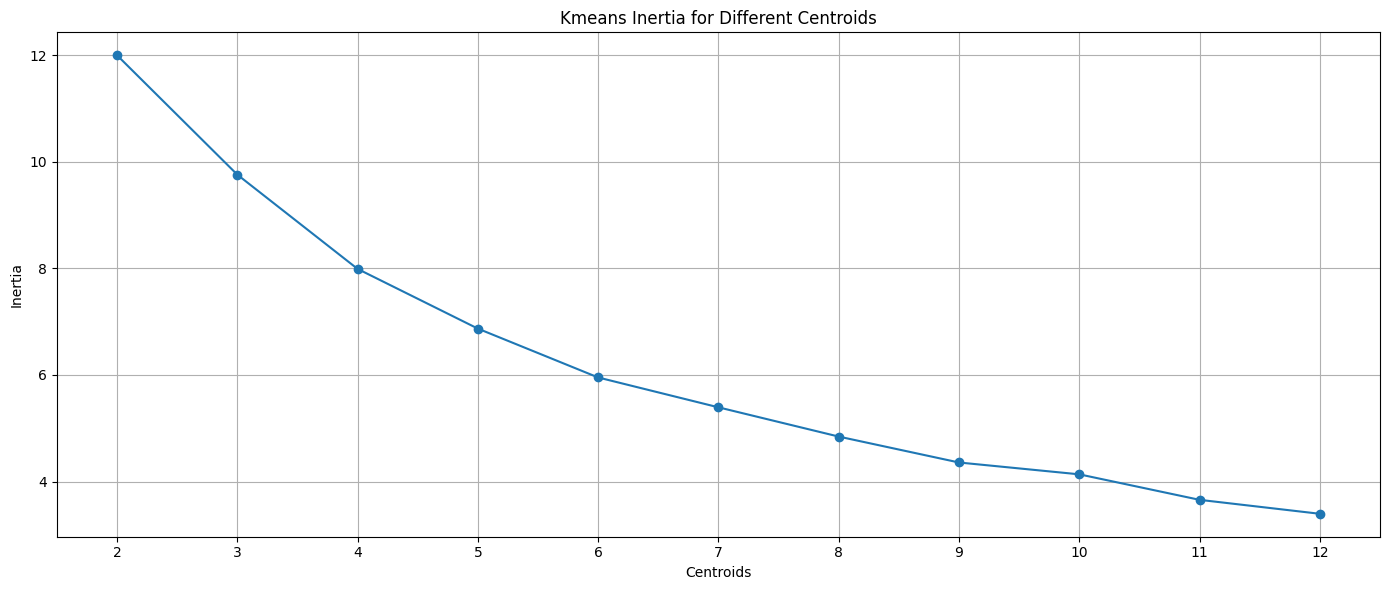

In [126]:
# KMeans clustering

max_k = 12
random_state = 42
inertia = []
silhouette = []
k_values = range(2, max_k+1)

for k in k_values:

    kmeans = KMeans(n_clusters=k, random_state=random_state, max_iter=1000) # initialize k centroids

    cluster_labels = kmeans.fit_predict(df_custom_scaled)  # cluster assignment for silhouette score

    #sil_score = silhouette_score(df_custom_scaled, cluster_labels) # silhouette score for k centroids

    inertia.append(kmeans.inertia_)

    #silhouette.append(sil_score)


plt.figure(figsize=(14,6))

plt.subplot(1,1,1)
plt.plot(k_values, inertia, marker='o')
plt.xticks(k_values)
plt.xlabel('Centroids')
plt.ylabel('Inertia')
plt.title('Kmeans Inertia for Different Centroids')
plt.grid(True)


plt.tight_layout()
plt.show()

In [127]:
# Five centroids chosen based on inertia 
kmeans = KMeans(n_clusters=5, random_state=random_state, max_iter=1000)

clusters_km = kmeans.fit_predict(df_custom_scaled)
clusters_km

array([2, 2, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 4, 2, 4, 4, 2, 4, 2, 4, 4, 3,
       4, 4, 4, 3, 2, 3, 3, 1, 4, 4, 2, 2, 2, 2, 4, 4, 2, 2, 2, 2, 4, 1,
       4, 4, 4, 2, 2, 4, 4, 4, 4, 4, 4, 0, 2, 0, 2, 2, 4, 0, 2, 2, 2, 4,
       4, 2, 4, 4, 4, 2, 1, 2, 2, 2, 2, 4, 4, 2, 2, 0, 0, 4, 2, 4, 2, 4,
       2, 2, 4, 2, 3, 4, 4, 4, 2, 4, 2, 4, 2, 4, 0, 4, 4, 4, 4, 3, 2, 4,
       4, 0, 2, 2, 2, 4, 2, 2, 2, 0, 1, 0, 0, 3, 2, 2, 2, 4, 0, 4, 4, 2,
       3, 4, 2, 4, 4, 2, 2, 4, 2, 4, 2, 0, 2, 2, 4, 2, 2, 2, 4, 4, 4, 2,
       2, 2, 4, 2, 2, 2, 4, 2, 2, 0, 2, 2], dtype=int32)

In [128]:
# value counts for each label (there are five cluster label)
df_clusters_km_sizes = pd.DataFrame(clusters_km).value_counts()
df_clusters_km_sizes

2    77
4    62
0    13
3    10
1     4
Name: count, dtype: int64

In [ ]:
# current state of matrix of selected features
df_custom_feats

,help_count,msf_count,bash_count,avg_gap,opt_changes
training_id,,,,,
hc_101,1,14.0,6,69.0,7
hc_112,0,29.0,31,97.0,18
hc_113,0,7.0,15,122.0,5
hc_115,0,11.0,13,178.0,9
hc_116,0,19.0,18,80.0,9
...,...,...,...,...,...
wb_329,0,10.0,43,54.0,19
wb_331,1,24.0,41,89.0,12
wb_351,0,15.0,152,45.0,34


In [ ]:
# add the cluster id to custom matrix
df_custom_feats['clusters_km'] = clusters_km
df_custom_feats.head()

,help_count,msf_count,bash_count,avg_gap,opt_changes,clusters_km
training_id,,,,,,
hc_101,1,14.0,6,69.0,7,2
hc_112,0,29.0,31,97.0,18,2
hc_113,0,7.0,15,122.0,5,3
hc_115,0,11.0,13,178.0,9,3
hc_116,0,19.0,18,80.0,9,2


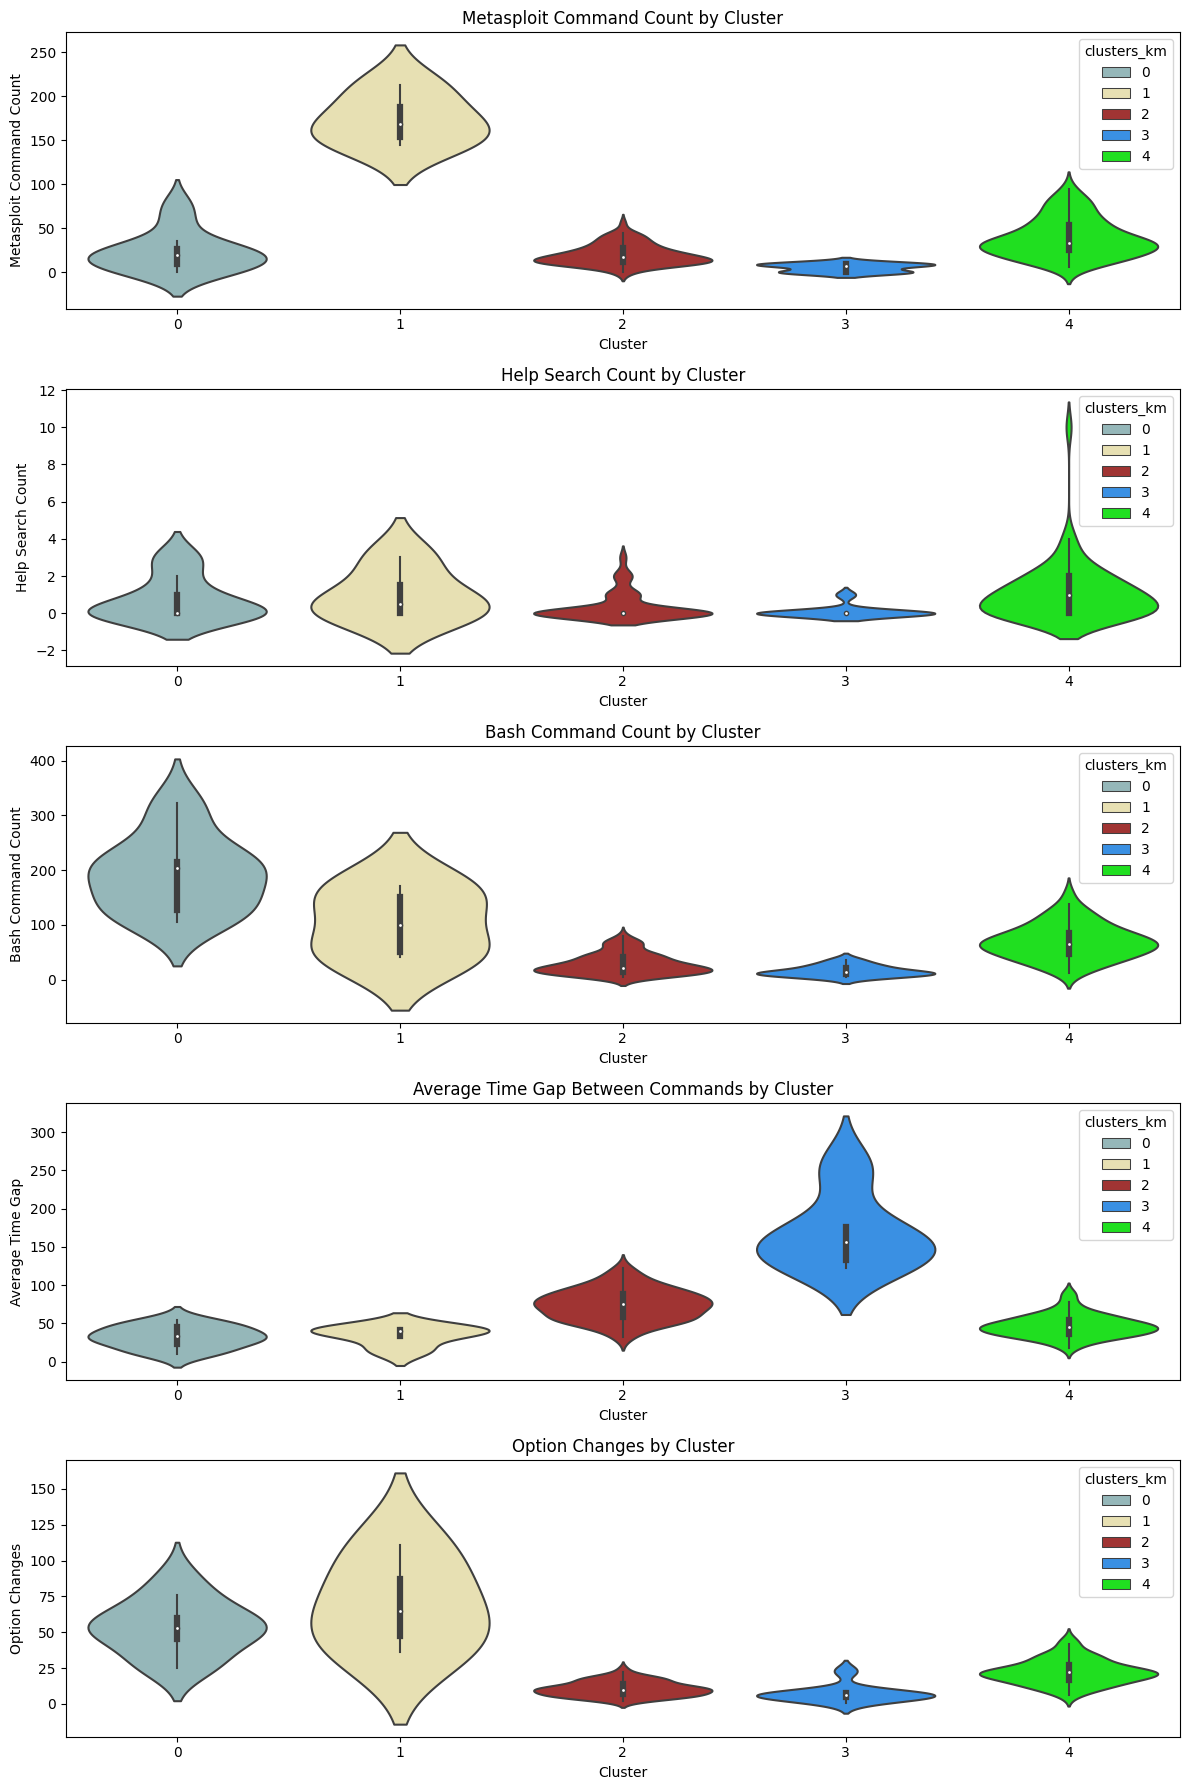

In [131]:
# Visualize distribution of features within KMeans clusters
cluster_colors = {0:'#8fbcbf',  # Green
                  1:'#f0e6aa',  # Yellow
                  2:'#b22221',  # Red
                  3:'#1e90ff',
                  4: '#00ff00'} # Lime
plt.figure(figsize=(12,18))

plt.subplot(5,1,1)
sns.violinplot(data=df_custom_feats, x='clusters_km', y='msf_count',palette=cluster_colors,
               hue='clusters_km', dodge=False)
plt.title('Metasploit Command Count by Cluster')
plt.ylabel('Metasploit Command Count')
plt.xlabel('Cluster')


plt.subplot(5,1,2)
sns.violinplot(data=df_custom_feats, x='clusters_km', y='help_count',palette=cluster_colors,
               hue='clusters_km', dodge=False)
plt.title('Help Search Count by Cluster')
plt.ylabel('Help Search Count')
plt.xlabel('Cluster')

plt.subplot(5,1,3)
sns.violinplot(data=df_custom_feats, x='clusters_km', y='bash_count',palette=cluster_colors,
               hue='clusters_km', dodge=False)
plt.title('Bash Command Count by Cluster')
plt.ylabel('Bash Command Count')
plt.xlabel('Cluster')

plt.subplot(5,1,4)
sns.violinplot(data=df_custom_feats, x='clusters_km', y='avg_gap',palette=cluster_colors,
               hue='clusters_km', dodge=False)
plt.title('Average Time Gap Between Commands by Cluster')
plt.ylabel('Average Time Gap')
plt.xlabel('Cluster')

plt.subplot(5,1,5)
sns.violinplot(data=df_custom_feats, x='clusters_km', y='opt_changes',palette=cluster_colors,
               hue='clusters_km', dodge=False)
plt.title('Option Changes by Cluster')
plt.ylabel('Option Changes')
plt.xlabel('Cluster')


plt.tight_layout()
plt.show()

KMeans cluster can be assigned names as follows:

0 = Bash Brute Forcers (A lot of bash commands and option changes, little time between submissions)

1 = Metasploit Brute Forcers (A lot of metasploit commands and option changes, little time between)

2 = Struggle Bus Participants   (Struggled because did not use help pages)

3 = Stuck Participants (Did not Progress far , did not use help and largest time gaps)

4 = Typical Participants (Used Help; no Brute Force (few option changes), Efficient use of time and resources)


In [132]:
df_cluster_describe = df_custom_feats.groupby('clusters_km').apply('describe')
df_cluster_help_count = (df_cluster_describe['help_count'])[['count','mean', 'min', 'max']]
df_cluster_msf_count = (df_cluster_describe['msf_count'])[['count','mean', 'min', 'max']]
df_cluster_bash_count = (df_cluster_describe ['bash_count'])[['count','mean', 'min', 'max']]
df_cluster_avg_gap = (df_cluster_describe ['avg_gap'])[['count','mean', 'min', 'max']]
df_cluster_opt_changes = (df_cluster_describe ['opt_changes'])[['count','mean', 'min', 'max']]

In [133]:
df_cluster_help_count.name = 'help_count'
df_cluster_help_count

,count,mean,min,max
clusters_km,,,,
0,13.0,0.769231,0.0,3.0
1,4.0,1.000000,0.0,3.0
2,77.0,0.376623,0.0,3.0
3,10.0,0.100000,0.0,1.0
4,62.0,1.096774,0.0,10.0


In [134]:
df_cluster_avg_gap

,count,mean,min,max
clusters_km,,,,
0,13.0,32.461538,10.0,55.0
1,4.0,34.500000,15.0,44.0
2,77.0,74.948052,32.0,123.0
3,10.0,168.600000,122.0,261.0
4,62.0,47.032258,18.0,90.0


In [135]:
df_cluster_opt_changes

,count,mean,min,max
clusters_km,,,,
0,13.0,53.461538,25.0,90.0
1,4.0,69.250000,36.0,111.0
2,77.0,10.727273,2.0,25.0
3,10.0,7.400000,1.0,23.0
4,62.0,22.500000,6.0,45.0


In [136]:
df_cluster_msf_count 

,count,mean,min,max
clusters_km,,,,
0,13.0,23.615385,0.0,78.0
1,4.0,173.750000,145.0,213.0
2,77.0,20.012987,0.0,56.0
3,10.0,5.300000,0.0,11.0
4,62.0,39.177419,6.0,95.0


In [137]:
df_cluster_bash_count

,count,mean,min,max
clusters_km,,,,
0,13.0,192.307692,106.0,322.0
1,4.0,103.000000,42.0,171.0
2,77.0,29.025974,5.0,80.0
3,10.0,16.100000,5.0,36.0
4,62.0,69.822581,12.0,158.0


#### Matrix of Selected Features Clustering Analysis

The matrix of selected features was clustered using KMeans algorithm because DBSCAN failed to find clusters due to how close all the matrix vectors were in cosine distance. An elbow analysis revealed that the optimal number of KMeans clusters is 5. KMeans as a partitional algorithm doesnt assign outliers. Cluster 0 had 13 trainees, cluster 1 had 4 trainees, cluster 2 had 77 trainees, cluster 3 had 10 trainees, cluster 4 had 62 trainees.


Cluster 0 had the largest number of Bash commands on average per participant and the smallest average time gap between their executed commands. These trainees used the tools' usage help up to 3 times. Cluster 0 trainees also had the second largest number of option changes. This suggests that Cluster 0 trainees used a brute-force in the Bash training modules, and may not have learned much.


Cluster 1 had the largest count of Metasploit commands and the second smallest average time gap between their submitted commands. These trainees used the tools' usage help up to 3 times. Cluster 0 trainees also had the largest number of option changes. This suggests that Cluster 1 trainees used a brute-force in the Metasploit training modules, and may not have learned much.

Cluster 2 trainees executed a second smallest number commands, option changes, tools' help page consult, and the second largest gap time between submitted commands. This suggests that Cluster 2 trainees did not use a brute-force approach but may have struggled through the training. This suggests that Cluster 2 trainees struggled, perhaps because they did not display the manual pages or the tools’ usage help enough.  Such unproductive behavior can be automatically recognized, along with notifying the instructors. 

Cluster 3 trainees had the largest average gap between submitted commands and the smallest number of commands, option changes and tools' help consult. This suggests that Cluster 3 trainees got stuck and did not progress far through the trainings. Based on this insight, instructors can again provide targeted help to trainees in this cluster. 

Cluster 4 trainees had the highest number of manual pages or the tools’ usage help. Cluster 4 trainees also has the third largest number of executed commands after Cluster 0 and 1. This suggests that Cluster 4 trainees did not brute force approach but diligently went through the training with sufficient checks on the help page. Cluster 4 trainees also had the third largest average time gap between commands.  This suggests that utilizing the help pages made Cluster 4 trainees more efficient with time. 

Overlaps with the bag of words clusters were minimal, suggesting that the results largely depend on the chosen features. Both approaches can provide useful insights; however, as in almost all machine learning approaches, it is difficult to select the best features.

Limitations of Clustering

The main limitation of clustering is that determining relevant features is hard. In addition, the relatively small sample size was problematic for the chosen clustering algorithm. Sometimes, only one cluster was formed, or only a few data points belonged to a cluster. Nevertheless, the format of the training implies that massive amounts of command histories cannot be collected.